# 초기 설정 및 모듈 불러오기

In [1]:
import warnings 

warnings.filterwarnings(action='ignore')

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import calmap
import calplot
from vega_datasets import data as vds
from datetime import datetime
from matplotlib import cm 
from matplotlib.colors import ListedColormap,LinearSegmentedColormap



matplotlib.rcParams['axes.unicode_minus'] = False

In [3]:
ColorGrid='#FEFEFE'
ColorLine1='#678BC4'
ColorLine2='#1D3059'

plt.rc('font', family='Malgun Gothic') 
plt.style.use('fivethirtyeight')
for param in ['figure.facecolor','axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#FEFEFE'  # 배경색깔 

for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '#050B1C'  # very light grey
plt.rcParams['axes.facecolor']='#E8EEF2'

pd.set_option('mode.chained_assignment',  None)

In [4]:
co=['#345595','#678BC4']
def pointing(x,y,ran,arr,m,up,bboxsize): # 점 찍는 함수, x : index, y : index, ran : 범위, m : max(True) min(False) ,up : 위치 조정, bboxsize : 박스 사이즈
    x=x[ran[0]:ran[1]]
    y=y[ran[0]:ran[1]]
    if m==True:
        arr.scatter(x[np.argmax(y)], np.max(y), 
                c=co[0],s=50, zorder=20)
        arr.text(x[np.argmax(y)], np.max(y)+up, s='{0}.{1:02d}.{2:02d}\n{3}'.format(x[np.argmax(y)].year, x[np.argmax(y)].month, x[np.argmax(y)].day, int(np.max(y))), fontweight='bold',
             va='bottom', ha='center', 
             bbox=dict(boxstyle='round,pad=0.3', fc=co[0], ec='black', alpha=0.3), size=bboxsize)
    
    else:
        arr.scatter(x[np.argmin(y)], np.min(y), 
                c=co[1],s=50, zorder=20)
        arr.text(x[np.argmin(y)], np.min(y)-up, s='{0}.{1:02d}.{2:02d}\n{3}'.format(x[np.argmin(y)].year, x[np.argmin(y)].month, x[np.argmin(y)].day, int(np.min(y))), fontweight='bold',
             va='top', ha='center', 
             bbox=dict(boxstyle='round,pad=0.3', fc=co[1], ec='black', alpha=0.3), size=bboxsize)
    return arr

In [5]:
def show_values_on_bars(axs, sizet):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() +10000
            value = round(p.get_height())
            ax.text(_x, _y, value, ha="center",size=sizet) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [6]:
def q(a):
    b=a//4
    li=[0,b]
    sumj=b
    for i in range(3):
        li.append(sumj+1)
        li.append(sumj+b)
        sumj+=b
    li.pop(-1)
    li.append(a)
    return li
a=q(62)
print(a)

[0, 15, 16, 30, 31, 45, 46, 62]


In [7]:
def fill_under(ax):
    # Get the two lines from the axes to generate shading
    l1 = ax.lines[0]

        # Get the xy data from the lines so that we can shade
    x1 = l1.get_xydata()[:,0]
    y1 = l1.get_xydata()[:,1]

    ax.fill_between(x1,y1, color=ColorLine1, alpha=0.1)
    return ax

In [8]:
# cmap custom colors~~
# create one colormaps
N = 256
a=[52, 85, 149]

one = np.ones((N, 4)) # 242, 133, 133
one[:, 0] = np.linspace(a[0]/256, 1, N) # R = 255
one[:, 1] = np.linspace(a[1]/256, 1, N) # G = 232
one[:, 2] = np.linspace(a[2]/256, 1, N)  # B = 11
one_cmp  = ListedColormap(one,reversed)
two = np.ones((N, 4)) # 242, 242, 242
two[:, 0] = np.linspace(35/256, 1, N)
two[:, 1] = np.linspace(63/256, 1, N)
two[:, 2] = np.linspace(103/256, 1, N)
two_cmp= ListedColormap(two)

newcolors2 = np.vstack((one_cmp(np.linspace(1, 0, 128))))
newcolors1 = np.vstack((one_cmp(np.linspace(0, 1, 128)),two_cmp(np.linspace(1, 0, 128))))
double = ListedColormap(newcolors2, name='double')
double2=ListedColormap(newcolors1, name='double2')

# COVID19 진행 상황

In [9]:
# raw 코로나 데이터 불러오기

covid_data=pd.read_csv('data/Covid_case.csv')

In [10]:
# 필요 칼럼만 추출
# 코로나 일별 확진자 수 칼럼 추가
# 정수형 stateDt를 Datetime형 stateDt로 변환 후 인덱스로 설정

covid_data['일별확진자']=covid_data.decideCnt.shift()-covid_data.decideCnt
covid_data_new=covid_data[['stateDt','일별확진자','decideCnt','deathCnt']]
covid_data_new.columns=['일자','일별확진자','누적확진자','누적사망자']
covid_data_new.index=pd.to_datetime(covid_data_new['일자'],format='%Y%m%d')
covid_data_new=covid_data_new.drop('일자',axis=1)
covid_data_new['년도']=covid_data_new.index.year
covid_data_new['월']=covid_data_new.index.month
covid_data_new.head()

,일별확진자,누적확진자,누적사망자,년도,월
일자,,,,,
2021-09-25,NaN,298401,2441.0,2021,9
2021-09-24,3269.0,295132,2434.0,2021,9
2021-09-23,2433.0,292699,2427.0,2021,9
2021-09-22,1716.0,290983,2419.0,2021,9
2021-09-21,1720.0,289263,2413.0,2021,9


In [11]:
# 일별 확진자수 분포 확인

covid_data_new.describe().일별확진자

count     603.000000
mean      494.860697
std       552.512534
min         0.000000
25%        61.500000
50%       363.000000
75%       645.500000
max      3269.000000
Name: 일별확진자, dtype: float64

<AxesSubplot:title={'center':'\nCOVID-19 일자별 누적 확진자\n'}, xlabel='일자', ylabel='누적확진자'>

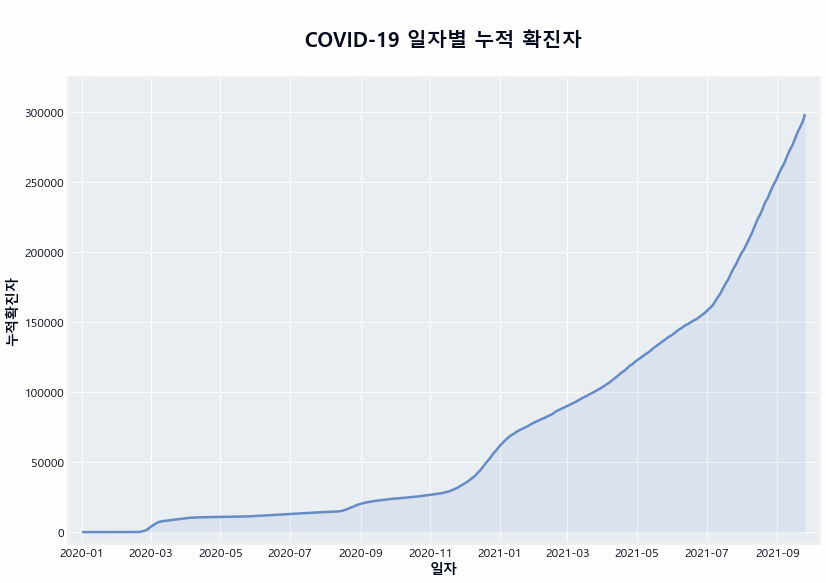

In [12]:
# 코로나 누적 확진자 시각화

plt.figure(figsize=(12,8))
plt.title('\nCOVID-19 일자별 누적 확진자\n', weight='bold')
plt.grid(color=ColorGrid)  # bluish dark grey, but slightly lighter than background

plt.margins(x=0.02)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('일자',fontdict={'weight': 'bold', 'size': 14})
plt.ylabel('누적확진자',fontdict={'weight': 'bold', 'size': 14})

ax=sns.lineplot(data=covid_data_new, x='일자', y='누적확진자',linewidth='2.5',color=ColorLine1)
ax.set_ylim([-8000,325000])
fill_under(ax)

<AxesSubplot:title={'center':'\n2020년 COVID-19 확진자수 히트맵\n'}>

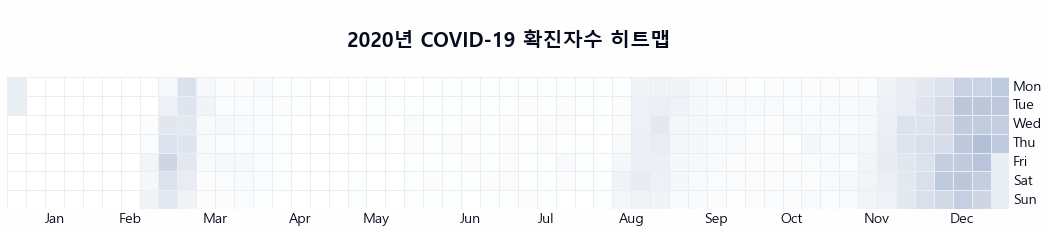

In [13]:
#코로나 확진자 수 히트맵(2020)

plt.figure(figsize=(16,8))
plt.title('\n2020년 COVID-19 확진자수 히트맵\n', weight='bold')
calmap.yearplot(data=covid_data_new['일별확진자'],year=2020,cmap=double)

<AxesSubplot:title={'center':'\n2021년 COVID-19 확진자수 히트맵\n'}>

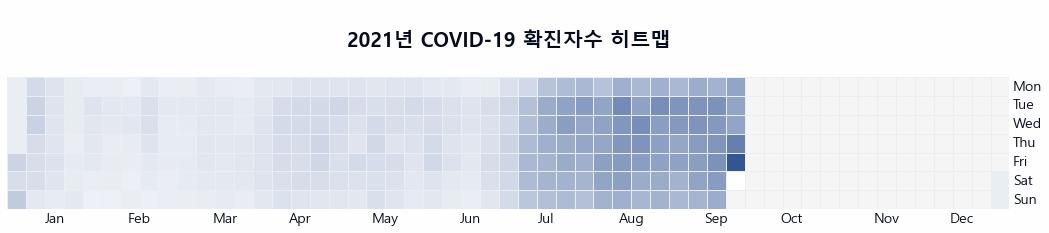

In [14]:
#코로나 확진자 수 히트맵(2021)

plt.figure(figsize=(16,8))
plt.title('\n2021년 COVID-19 확진자수 히트맵\n', weight='bold')
calmap.yearplot(data=covid_data_new['일별확진자'],year=2021, cmap=double)

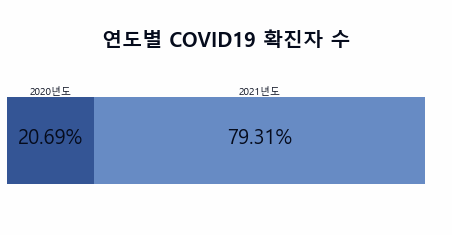

In [15]:
# 코로나 년도별 확진자 시각화

year_covid=pd.DataFrame(covid_data_new.groupby('년도')['일별확진자'].sum()).T

total_decideCnt=year_covid[2020]+year_covid[2021]

ax = year_covid.plot(kind='barh', stacked=True, rot=0,figsize=(7,3),color=['#345595', '#678BC4'])
plt.title('\n연도별 COVID19 확진자 수',weight='bold')
for idx, p in enumerate(ax.patches):
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(f"\n\n{(width*100)/int(total_decideCnt):.2f}%", xy=(left+width/2, (bottom+height)*3/5), ha='center', va='center',fontsize=20)
    ax.annotate(f"{2020+idx}년도", xy=(left+width/2, bottom+height), ha='center', va='bottom',fontsize=10)
plt.box(False)
ax.set_xticks([])
ax.set_yticks([])
ax.get_legend().remove()
plt.show()

<AxesSubplot:title={'center':'\nCOVID-19 일자별 확진자 수\n'}, xlabel='일자', ylabel='일별확진자'>

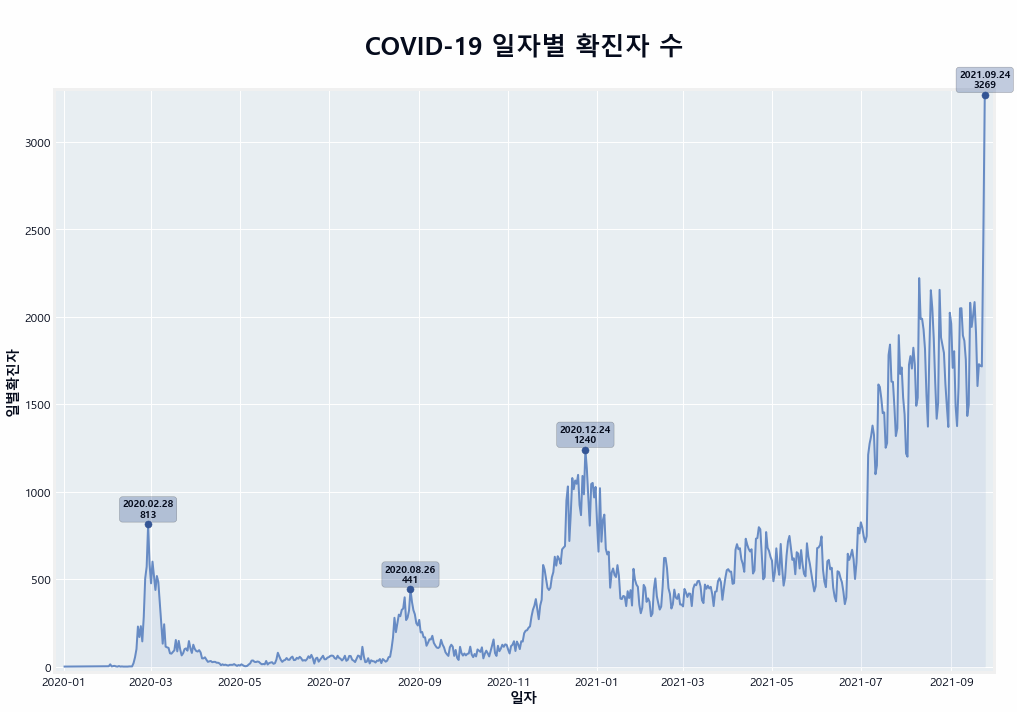

In [16]:
# 코로나 일별 확진자 시각화

plt.figure(figsize=(15,10))
plt.title('\nCOVID-19 일자별 확진자 수\n', weight='bold', size=25)
plt.grid(color=ColorGrid)  # bluish dark grey, but slightly lighter than background

plt.margins(x=0.01,y=0.01)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('일자',fontdict={'weight': 'bold', 'size': 14})
plt.ylabel('일별확진자',fontdict={'weight': 'bold', 'size': 14})

ax=plt.gca()
x=covid_data_new.index
y=covid_data_new.일별확진자

ax=pointing(x,y,[0,20],ax,True,30,10)
ax=pointing(x,y,[200,300],ax,True,30,10)
ax=pointing(x,y,[350,500],ax,True,30,10)
ax=pointing(x,y,[550,800],ax,True,30,10)


ax=sns.lineplot(data=covid_data_new, x='일자', y='일별확진자',color=ColorLine1, linewidth='2')
fill_under(ax)

위 세가지 그래프의 일별/년도별 확진자 확인 결과, 2020년 3월, 2020년 8월, 2020년 12월, 2021년 8월 총 4차례의 대유행이 발생 했음을 알 수 있다

In [17]:
# 대유행 기간 확진자 수 추출

covid_data_1st_pandemic=covid_data_new[(covid_data_new.년도==2020) & ((covid_data_new.월==2)|(covid_data_new.월==3))]
covid_data_2nd_pandemic=covid_data_new[(covid_data_new.년도==2020) & ((covid_data_new.월==8)|(covid_data_new.월==9))]
covid_data_3rd_pandemic=covid_data_new[((covid_data_new.년도==2020) & ((covid_data_new.월==12)|(covid_data_new.월==11)))|
                ((covid_data_new.년도==2021)&((covid_data_new.월==1)|(covid_data_new.월==2)))]
covid_data_4th_pandemic=covid_data_new[(covid_data_new.년도==2021) & ((covid_data_new.월==6)|(covid_data_new.월==7)|(covid_data_new.월==8)|(covid_data_new.월==9))]

<AxesSubplot:title={'center':'\n4차 대유행\n'}, xlabel='일자', ylabel='일별확진자'>

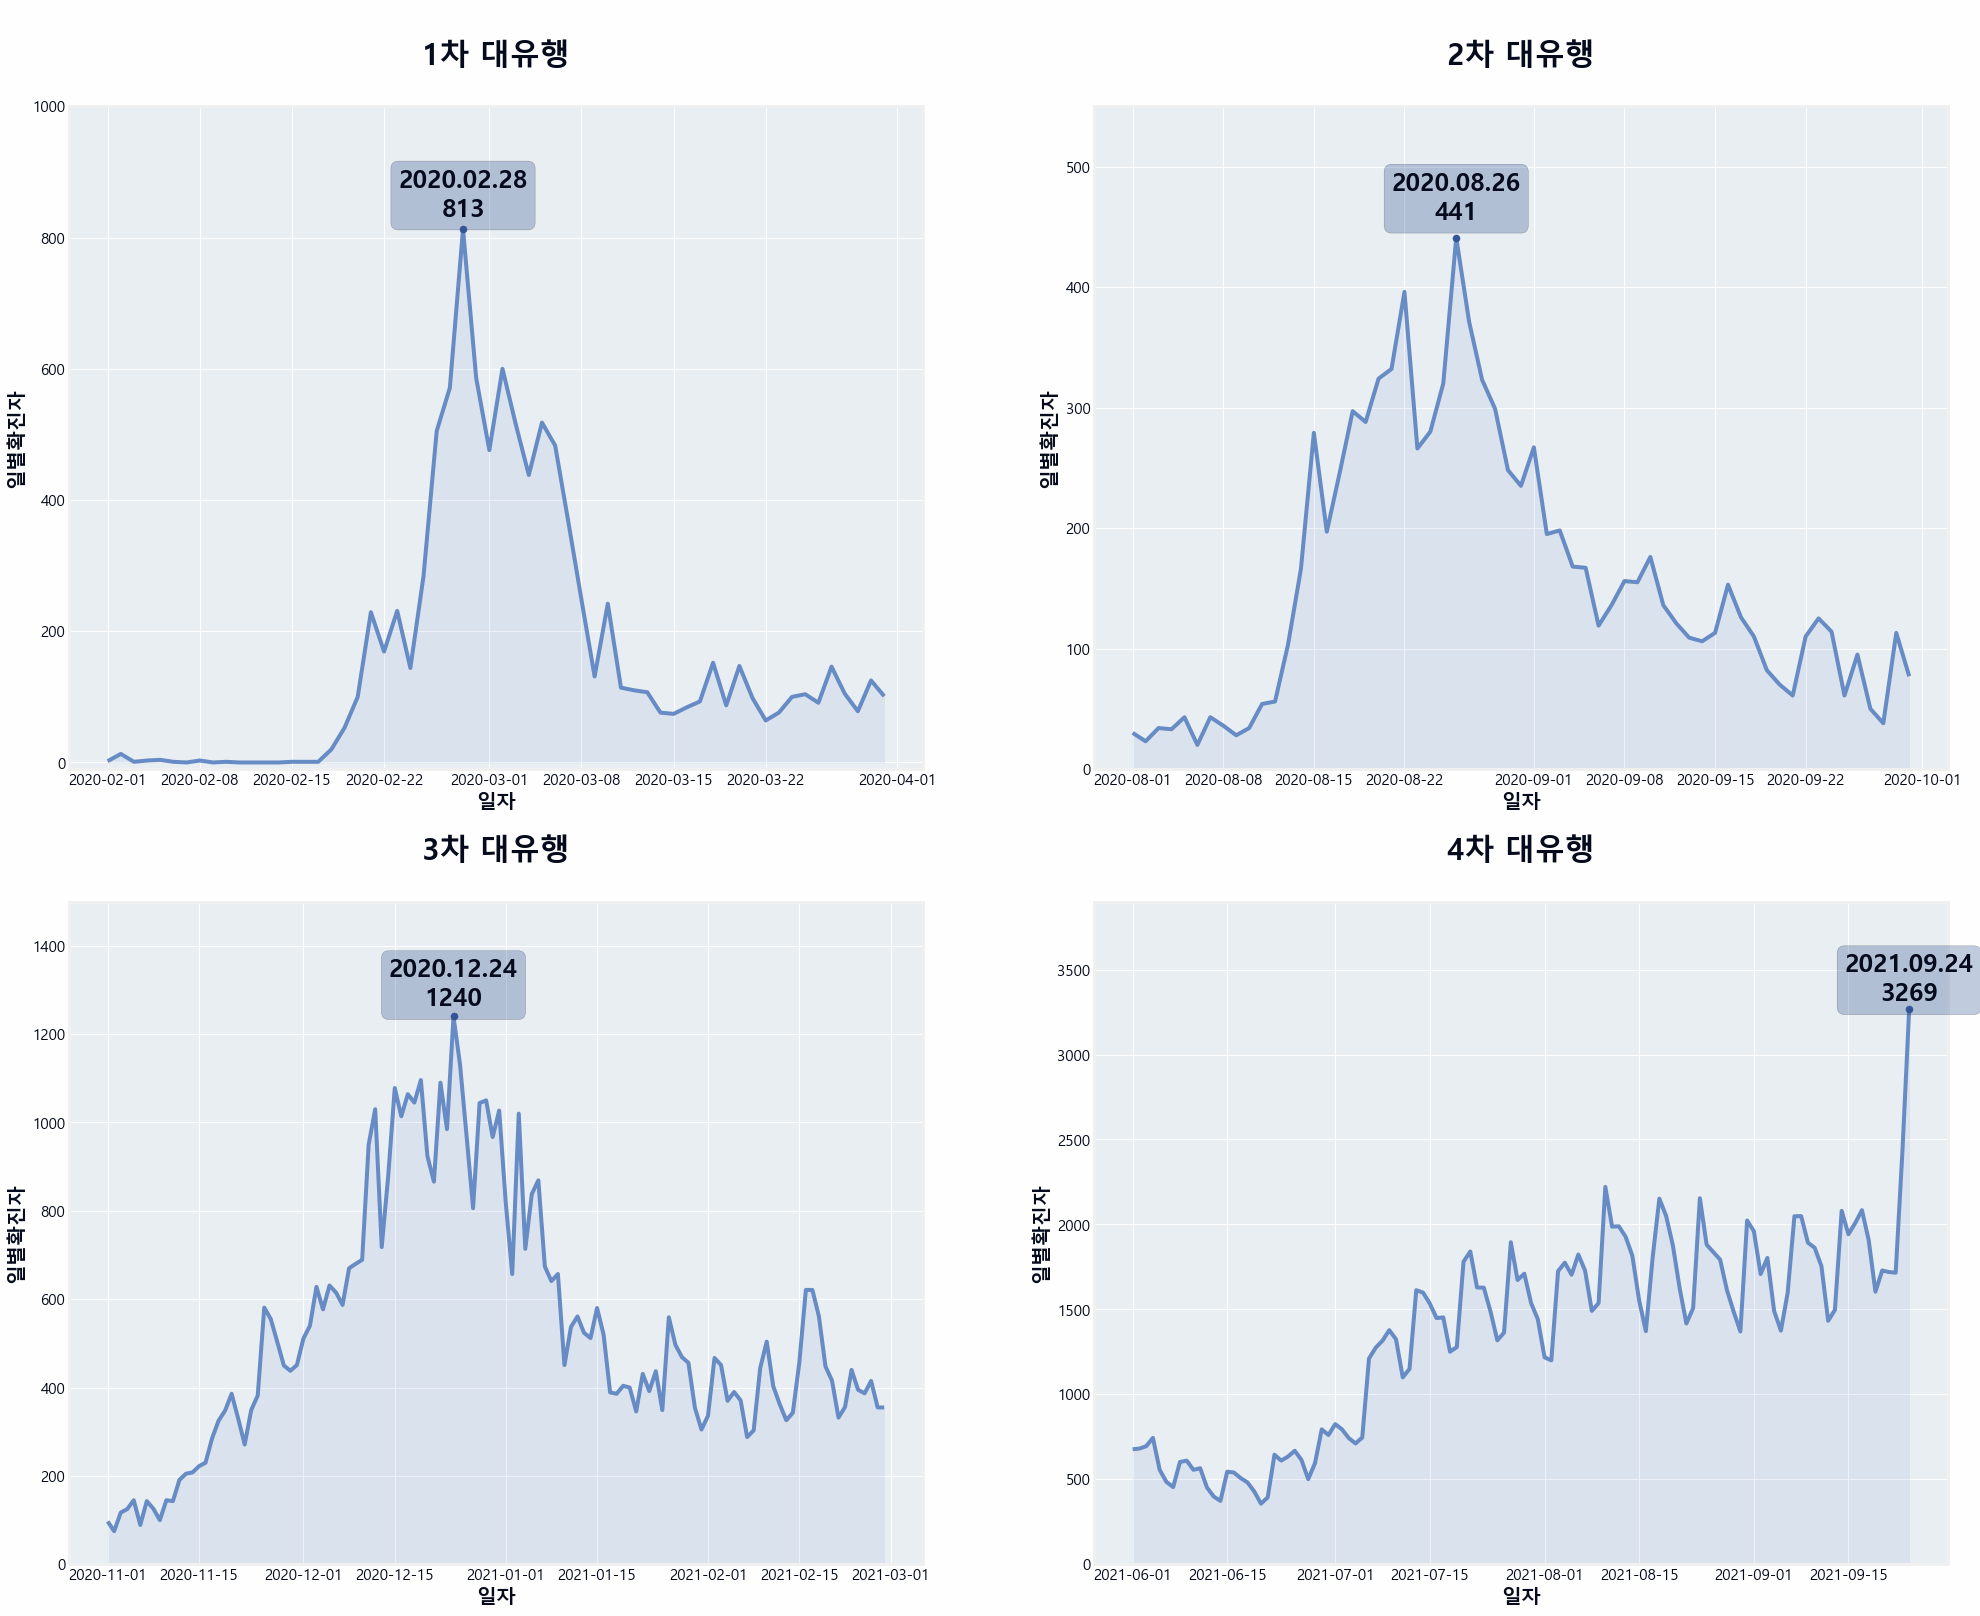

In [59]:
# 대유행 기간 확진자 수 시각화

fig, axes=plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(30,25)

axes[0][0].set_title('\n1차 대유행\n', weight='bold', size=30)
axes[0][1].set_title('\n2차 대유행\n', weight='bold', size=30)
axes[1][0].set_title('\n3차 대유행\n', weight='bold', size=30)
axes[1][1].set_title('\n4차 대유행\n', weight='bold', size=30)
li=[[covid_data_1st_pandemic,covid_data_2nd_pandemic],[covid_data_3rd_pandemic, covid_data_4th_pandemic]]
for i in range(2):
    for j in range(2):
        axes[i][j].grid(color=ColorGrid)  # bluish dark grey, but slightly lighter than background
        axes[i][j].tick_params(axis='x', labelsize=15)
        axes[i][j].tick_params(axis='y', labelsize=15)
        axes[i][j].set_xlabel('일자',fontsize=20,weight='bold')
        axes[i][j].set_ylabel('일별확진자',fontsize=20,weight='bold')
        axes[i][j]=pointing(li[i][j].index,li[i][j].일별확진자 , [0,-1],axes[i][j],True,10,25)
axes[0][0].set_ylim([-10,1000])
axes[0][1].set_ylim([0,550])
axes[1][0].set_ylim([0,1500])
axes[1][1].set_ylim([0,3900])

fill_under(sns.lineplot(data=covid_data_1st_pandemic,x='일자', y='일별확진자', ax=axes[0][0],color=ColorLine1))
fill_under(sns.lineplot(data=covid_data_2nd_pandemic,x='일자', y='일별확진자', ax=axes[0][1],color=ColorLine1))
fill_under(sns.lineplot(data=covid_data_3rd_pandemic,x='일자', y='일별확진자', ax=axes[1][0],color=ColorLine1))
fill_under(sns.lineplot(data=covid_data_4th_pandemic,x='일자', y='일별확진자', ax=axes[1][1],color=ColorLine1))

4차례의 대유행이 시각화로 뚜렷하게 표현되며, 4차 대유행은 여전히 진행중이다.

# 고속도로 이용 교통량 추이

In [19]:
# 년도별/분기별 교통량 데이터 가져오기

traffic_2018_01=pd.read_csv('data/2018_01분기.csv',encoding='cp949')
traffic_2018_02=pd.read_csv('data/2018_02분기.csv',encoding='cp949')
traffic_2018_03=pd.read_csv('data/2018_03분기.csv',encoding='cp949')
traffic_2018_04=pd.read_csv('data/2018_04분기.csv',encoding='cp949')
traffic_2019_01=pd.read_csv('data/2019_01분기.csv',encoding='cp949')
traffic_2019_02=pd.read_csv('data/2019_02분기.csv',encoding='cp949')
traffic_2019_03=pd.read_csv('data/2019_03분기.csv',encoding='cp949')
traffic_2019_04=pd.read_csv('data/2019_04분기.csv',encoding='cp949')
traffic_2020_01=pd.read_csv('data/2020_01분기.csv',encoding='cp949')
traffic_2020_02=pd.read_csv('data/2020_02분기.csv',encoding='cp949')
traffic_2020_03=pd.read_csv('data/2020_03분기.csv',encoding='cp949')
traffic_2020_04=pd.read_csv('data/2020_04분기.csv',encoding='cp949')
traffic_2021_01=pd.read_csv('data/2021_01분기.csv',encoding='cp949')
traffic_2021_02=pd.read_csv('data/2021_02분기.csv',encoding='cp949')

In [20]:
# 분기별 데이터 하나의 데이터로 합치기

traffic_data=pd.concat([traffic_2018_01,traffic_2018_02,traffic_2018_03,traffic_2018_04,
                        traffic_2019_01,traffic_2019_02,traffic_2019_03,traffic_2019_04,
                        traffic_2020_01,traffic_2020_02,traffic_2020_03,traffic_2020_04,
                        traffic_2021_01,traffic_2021_02])
# 명칭이 불규칙하여 통일

traffic_data=traffic_data.replace('서서울영업소','서서울')
traffic_data=traffic_data.replace('서울영업소','서울')
traffic_data=traffic_data.replace('서대구영업소','서대구')
traffic_data=traffic_data.replace('북대구영업소','북대구')
traffic_data=traffic_data.replace('남대구영업소','남대구')
traffic_data=traffic_data.replace('북강릉영업소','북강릉')
traffic_data=traffic_data.replace('남강릉영업소','남강릉')
traffic_data=traffic_data.replace('강릉영업소','강릉')

In [21]:
def day_of_week(traffic_data): #요일 추가 함수
    traffic_data.index=pd.to_datetime(traffic_data.index, format='%Y%m%d')
    traffic_data['년도']=traffic_data.index.year 
    traffic_data['월']=traffic_data.index.month
    days={0:'월요일',1:'화요일',2:'수요일',3:'목요일',4:'금요일',5:'토요일',6:'일요일'}
    traffic_data['요일']=traffic_data.index.dayofweek 
    traffic_data.요일=traffic_data.요일.apply(lambda x : days[x])
    return traffic_data

In [22]:
# 필요 칼럼만 추출
# 정수형 집계일자를 Datetime형 집계일자로 변환 후 인덱스로 설정
# 일별 년도/월/요일 칼럼 추가

traffic_data.index=traffic_data.집계일자
traffic_data=traffic_data.drop('집계일자',axis=1)
traffic_data=traffic_data[['영업소명','1종교통량', '2종교통량','3종교통량', '4종교통량', '5종교통량', '6종교통량', '총교통량']]
traffic_data=day_of_week(traffic_data)
traffic_data.head()

,영업소명,1종교통량,2종교통량,3종교통량,4종교통량,5종교통량,6종교통량,총교통량,년도,월,요일
집계일자,,,,,,,,,,,
2018-01-01,가락,211,6,6,21,27,4,275,2018,1,월요일
2018-01-01,가락,615,14,5,14,96,26,770,2018,1,월요일
2018-01-01,가락(개),2358,31,48,57,131,273,2898,2018,1,월요일
2018-01-01,가락(개),7148,27,71,27,267,378,7918,2018,1,월요일
2018-01-01,가락(개),2946,29,52,48,150,357,3582,2018,1,월요일


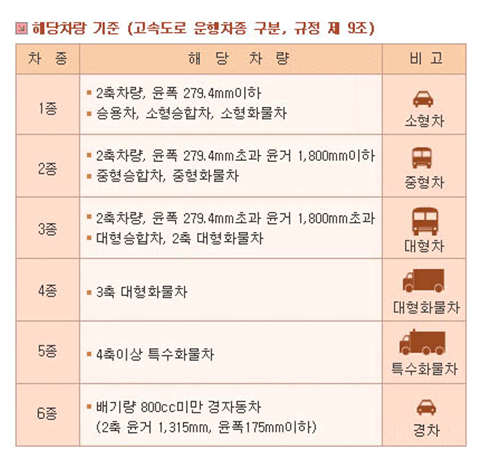

## 전국 교통량 분석

In [23]:
# 모든 곳의 톨게이트에 대한 교통량 합산

traffic_data_total=traffic_data.groupby('집계일자')['1종교통량', '2종교통량','3종교통량', '4종교통량', '5종교통량', '6종교통량', '총교통량'].sum()
traffic_data_total=day_of_week(traffic_data_total)
# 년도별 저장

traffic_data_2018=traffic_data_total[traffic_data_total.년도==2018]
traffic_data_2019=traffic_data_total[traffic_data_total.년도==2019]
traffic_data_2020=traffic_data_total[traffic_data_total.년도==2020]
traffic_data_2021=traffic_data_total[traffic_data_total.년도==2021]

# 코로나 기간 저장

traffic_data_2020_2021=traffic_data_total[(traffic_data_total.년도==2020)|(traffic_data_total.년도==2021)]
traffic_data_total.head()

,1종교통량,2종교통량,3종교통량,4종교통량,5종교통량,6종교통량,총교통량,년도,월,요일
집계일자,,,,,,,,,,
2018-01-01,5562671,64729,140284,36796,34705,240045,6079230,2018,1,월요일
2018-01-02,4945308,200328,257620,163881,234282,290196,6091615,2018,1,화요일
2018-01-03,4841053,232174,293244,212214,294425,289377,6162487,2018,1,수요일
2018-01-04,4902656,232305,293413,209227,300632,291083,6229316,2018,1,목요일
2018-01-05,5342859,233726,299322,209493,299666,310678,6695744,2018,1,금요일


Text(0.5, 0.98, '\n요일별 교통량\n')

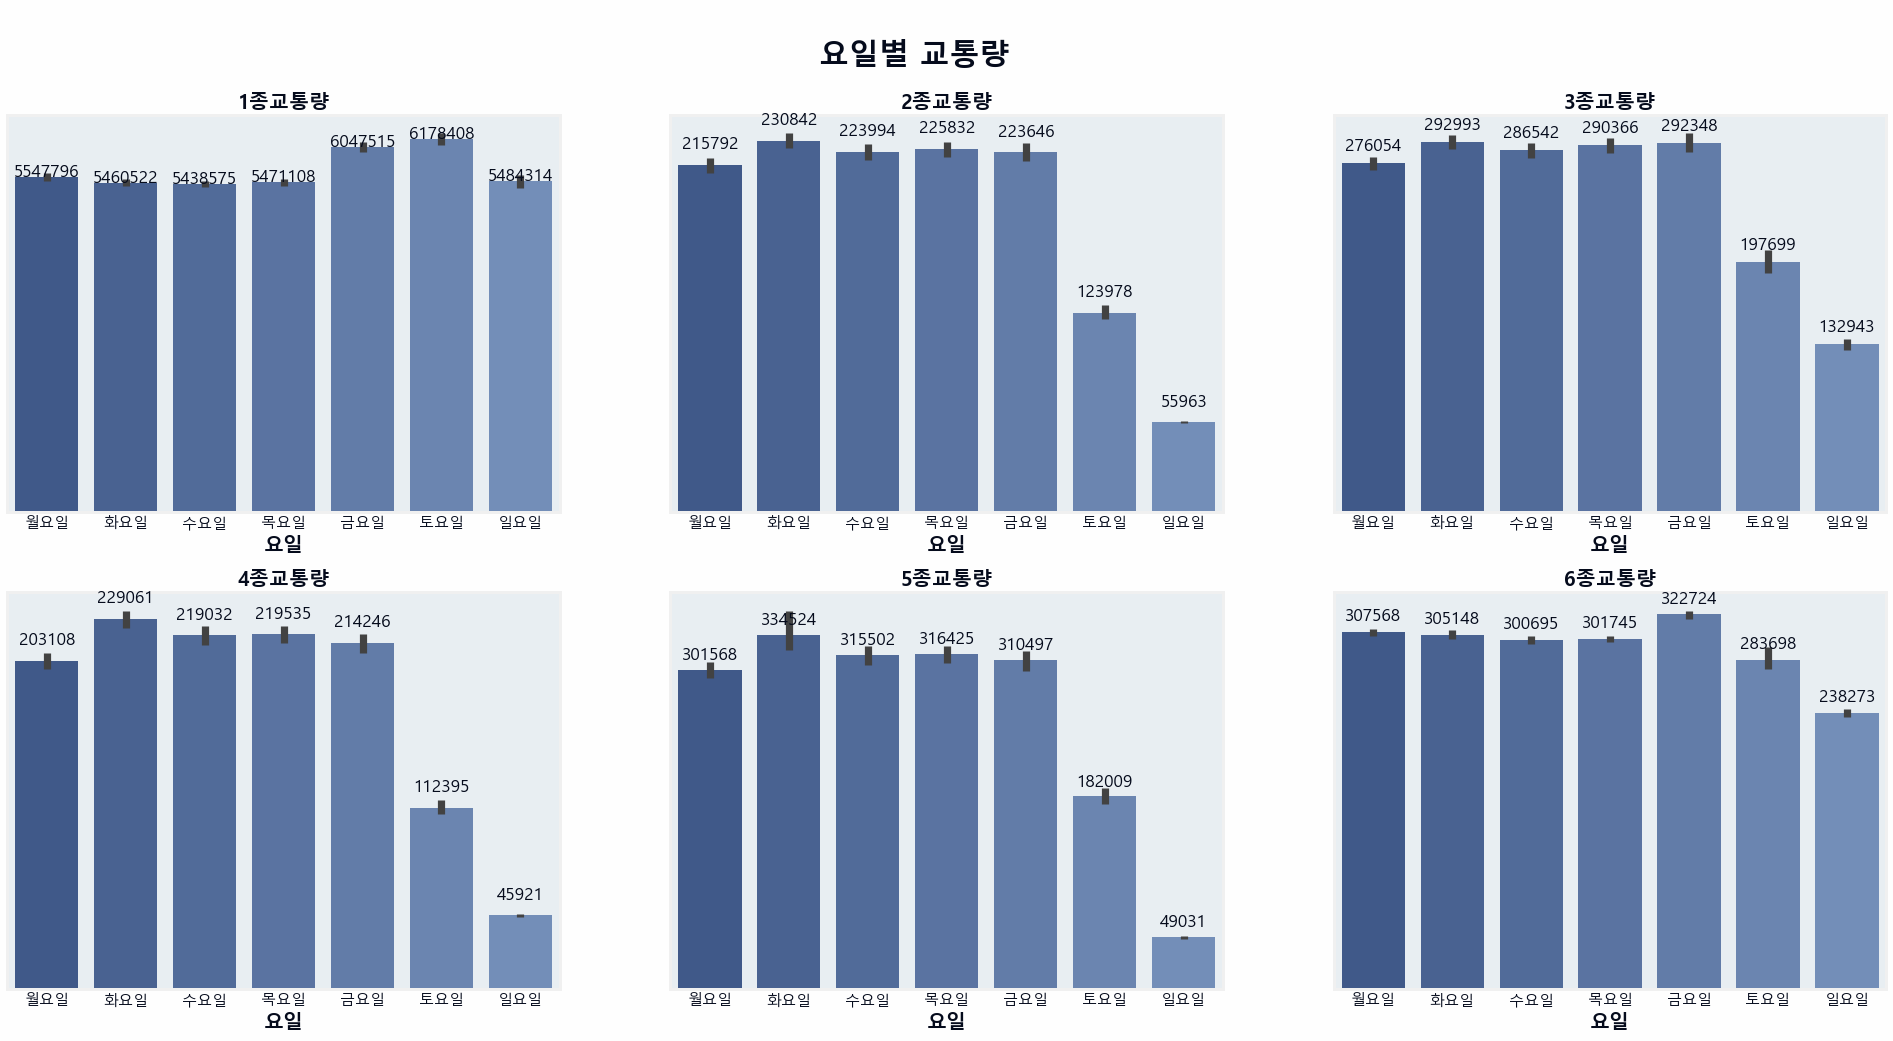

In [60]:
# 요일별 차종 평균 그래프 시각화
# lim 설정하면 안보여 ㅠ
traffic=[['1종교통량','2종교통량','3종교통량'],['4종교통량','5종교통량','6종교통량']]
fig, axes=plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(30,15)
colors = ['#345595','#3D5E9D','#4567A5','#4E70AD','#5679B4','#5F82BC','#678BC4']

for i in range(2):
    for j in range(3):
        #axes[i][j].set_ylim([0,9000000])
        axes[i][j].grid(color=ColorGrid) 
        axes[i][j].get_yaxis().get_major_formatter().set_scientific(False)
        axes[i][j].set_title(traffic[i][j], weight='bold')
        axes[i][j].tick_params(axis='x', labelsize=15)
        axes[i][j].yaxis.set_major_locator(plt.NullLocator())
        axes[i][j].get_yaxis().set_visible(False)
        axes[i][j].set_xlabel('요일',fontsize=20,weight='bold')
        sns.barplot(x='요일', y=traffic[i][j], data=traffic_data_total,ax=axes[i][j],palette=colors)
        show_values_on_bars(axes[i][j],17)
        
plt.suptitle('\n요일별 교통량\n',weight='bold', fontsize=30)

요일별 교통량을 확인해본 결과, 1종 교통의 교통량은 요일과 관계없이 거의 비슷하다.
2종부터 6종까지의 교통량은 주말이 적으며, 평일이 많다.
이는 근무를 위해 움직이는 사람들의 교통량에 의해서 많다고 생각되어지며,
개인적인 일로 움직이는 교통량을 확인하기 위해서는 주말의 교통량을 확인해볼 필요가 있다고 생각된다.
또한, 1종 교통량 혹은 총 교통량보다는 나머지 교통량을 확인해보는 것이 뚜렷한 변화를 확인해볼 수 있을 것 같다.

Text(0.5, 0.98, '\n차종별 교통량\n')

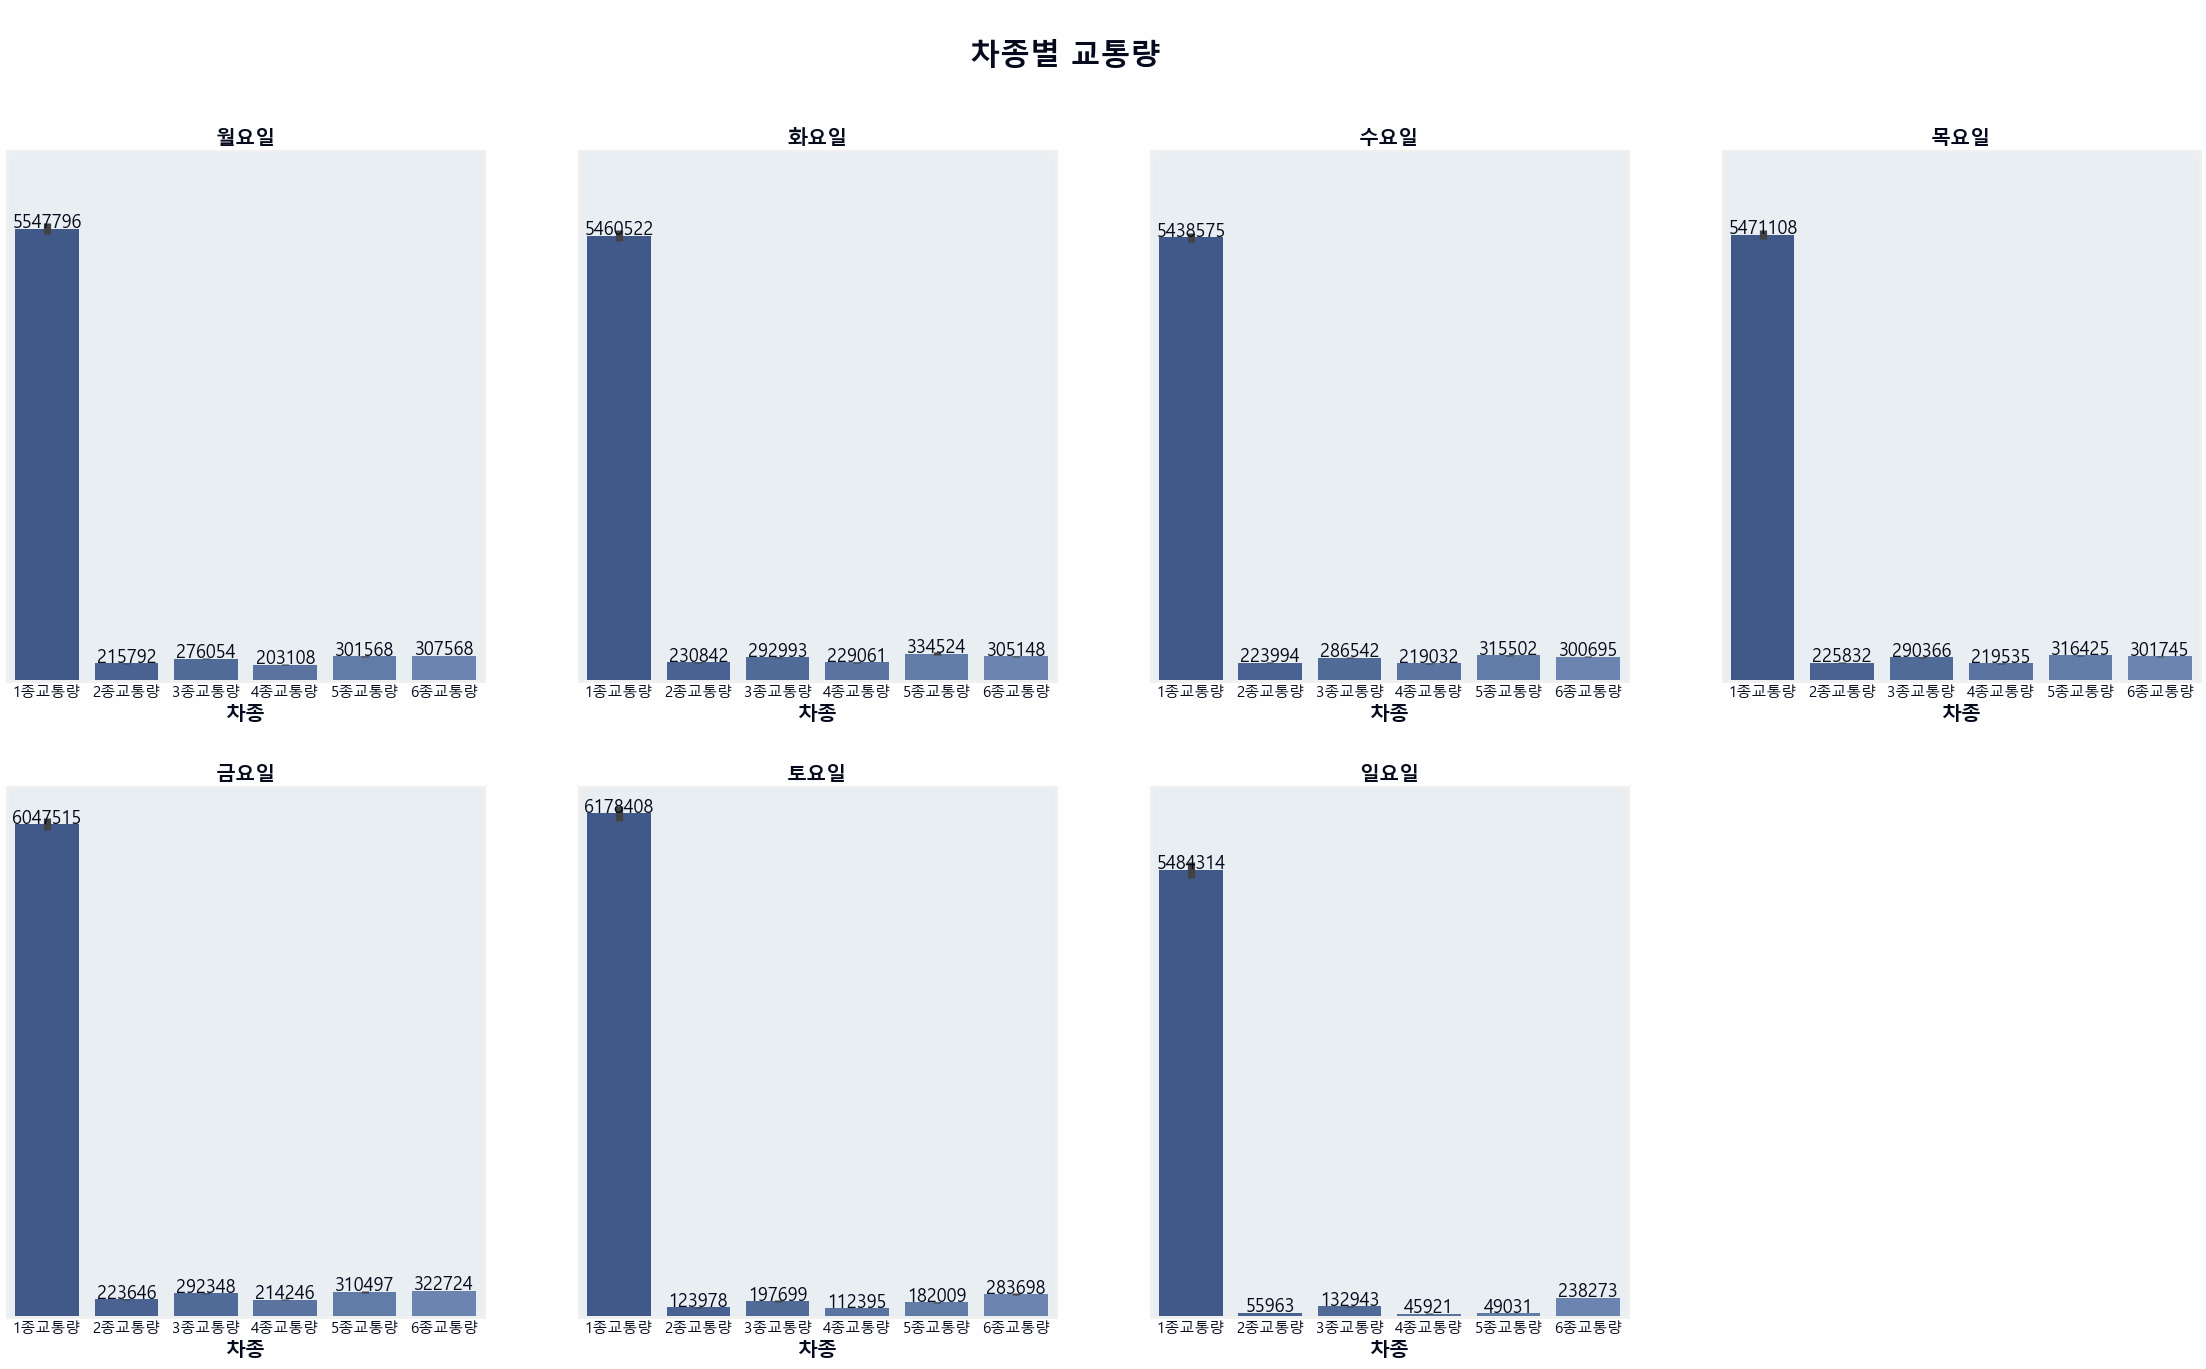

In [61]:
# 차종별 요일 교통량 그래프 시각화
# lim 설정하면 안보여 ㅠ
traffic=[['월요일','화요일','수요일','목요일'],['금요일','토요일','일요일',None]]
fig, axes=plt.subplots(nrows=2, ncols=4)
fig.set_size_inches(35,20)

for i in range(2):
    for j in range(4):
        if i==1 and j==3: break
        axes[i][j].grid(color=ColorGrid) 
        axes[i][j].set_ylim([0,6500000])
        axes[i][j].get_yaxis().get_major_formatter().set_scientific(False)
        melted=traffic_data_total[traffic_data_total['요일']==traffic[i][j]]
        melted=melted.drop(['년도','월','요일','총교통량'],axis=1)
        melted=pd.melt(melted)
        melted.columns=['차종','교통량']
        axes[i][j].tick_params(axis='x', labelsize=15)
        axes[i][j].tick_params(axis='y', labelsize=15)
        axes[i][j].set_xlabel('차종',fontsize=20,weight='bold')
        axes[i][j].set_ylabel('교통량',fontsize=20,weight='bold')
        axes[i][j].set_title(traffic[i][j], weight='bold')
        axes[i][j].yaxis.set_major_locator(plt.NullLocator())
        axes[i][j].get_yaxis().set_visible(False)
        sns.barplot(x='차종',y='교통량',data=melted,ax=axes[i][j],palette=colors)
        show_values_on_bars(axes[i][j],18)
axes[1][3].remove()

plt.suptitle('\n차종별 교통량\n',weight='bold', fontsize=30)

### 전국 교통량 추이 확인 - 1종 교통량

<AxesSubplot:title={'center':'\n전국 1종 교통량(2020-2021)\n'}, xlabel='일자', ylabel='1종교통량'>

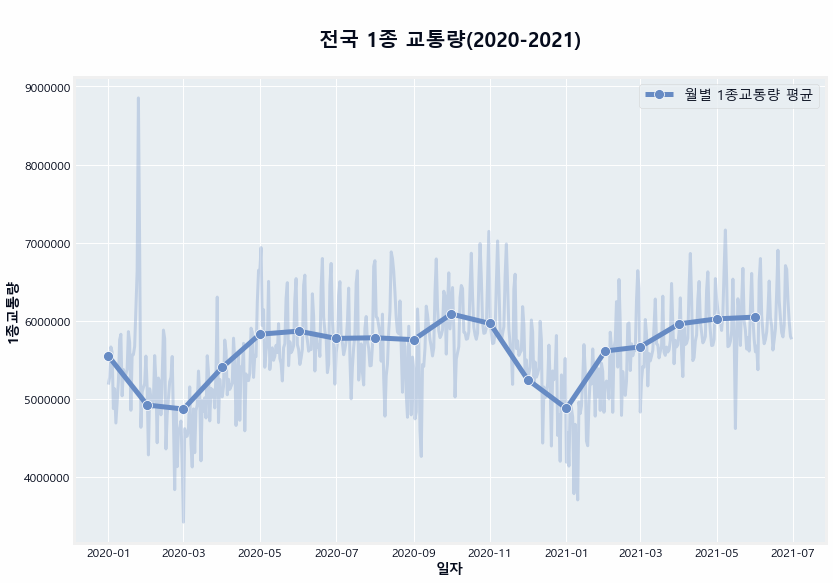

In [26]:
# 1종 교통량(대부분의 자가용) 분석 

data=pd.DataFrame(traffic_data_total[((traffic_data_total.년도==2020)|(traffic_data_total.년도==2021))].groupby(['년도','월'])['1종교통량'].mean())
time=[]
for i in range(len(data.index)):
    time.append(str(data.index[i][0])+'-'+str(data.index[i][1])+'-1')
data['날짜 중앙값']=time
data['날짜 중앙값']=pd.to_datetime(data['날짜 중앙값'],format='%Y-%m-%d')


plt.figure(figsize=(12,8)) 
plt.grid(color=ColorGrid) 
plt.title('\n전국 1종 교통량(2020-2021)\n', weight='bold')
plt.margins(x=0.05,y=0.05)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('일자',fontdict={'weight': 'bold', 'size': 14})
plt.ylabel('1종교통량',fontdict={'weight': 'bold', 'size': 14})

ax=plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)

sns.lineplot(data=traffic_data_total[((traffic_data_total.년도==2020)|(traffic_data_total.년도==2021))], x='집계일자', y='1종교통량',color=ColorLine1, alpha=0.3, linewidth='3')
sns.lineplot(data=data, x='날짜 중앙값', y='1종교통량',color=ColorLine1,linewidth='5',marker='o',markersize=10,label='월별 1종교통량 평균')

390


<AxesSubplot:title={'center':'\n전국 주말 1종 교통량(2020-2021)\n'}, xlabel='일자', ylabel='1종교통량'>

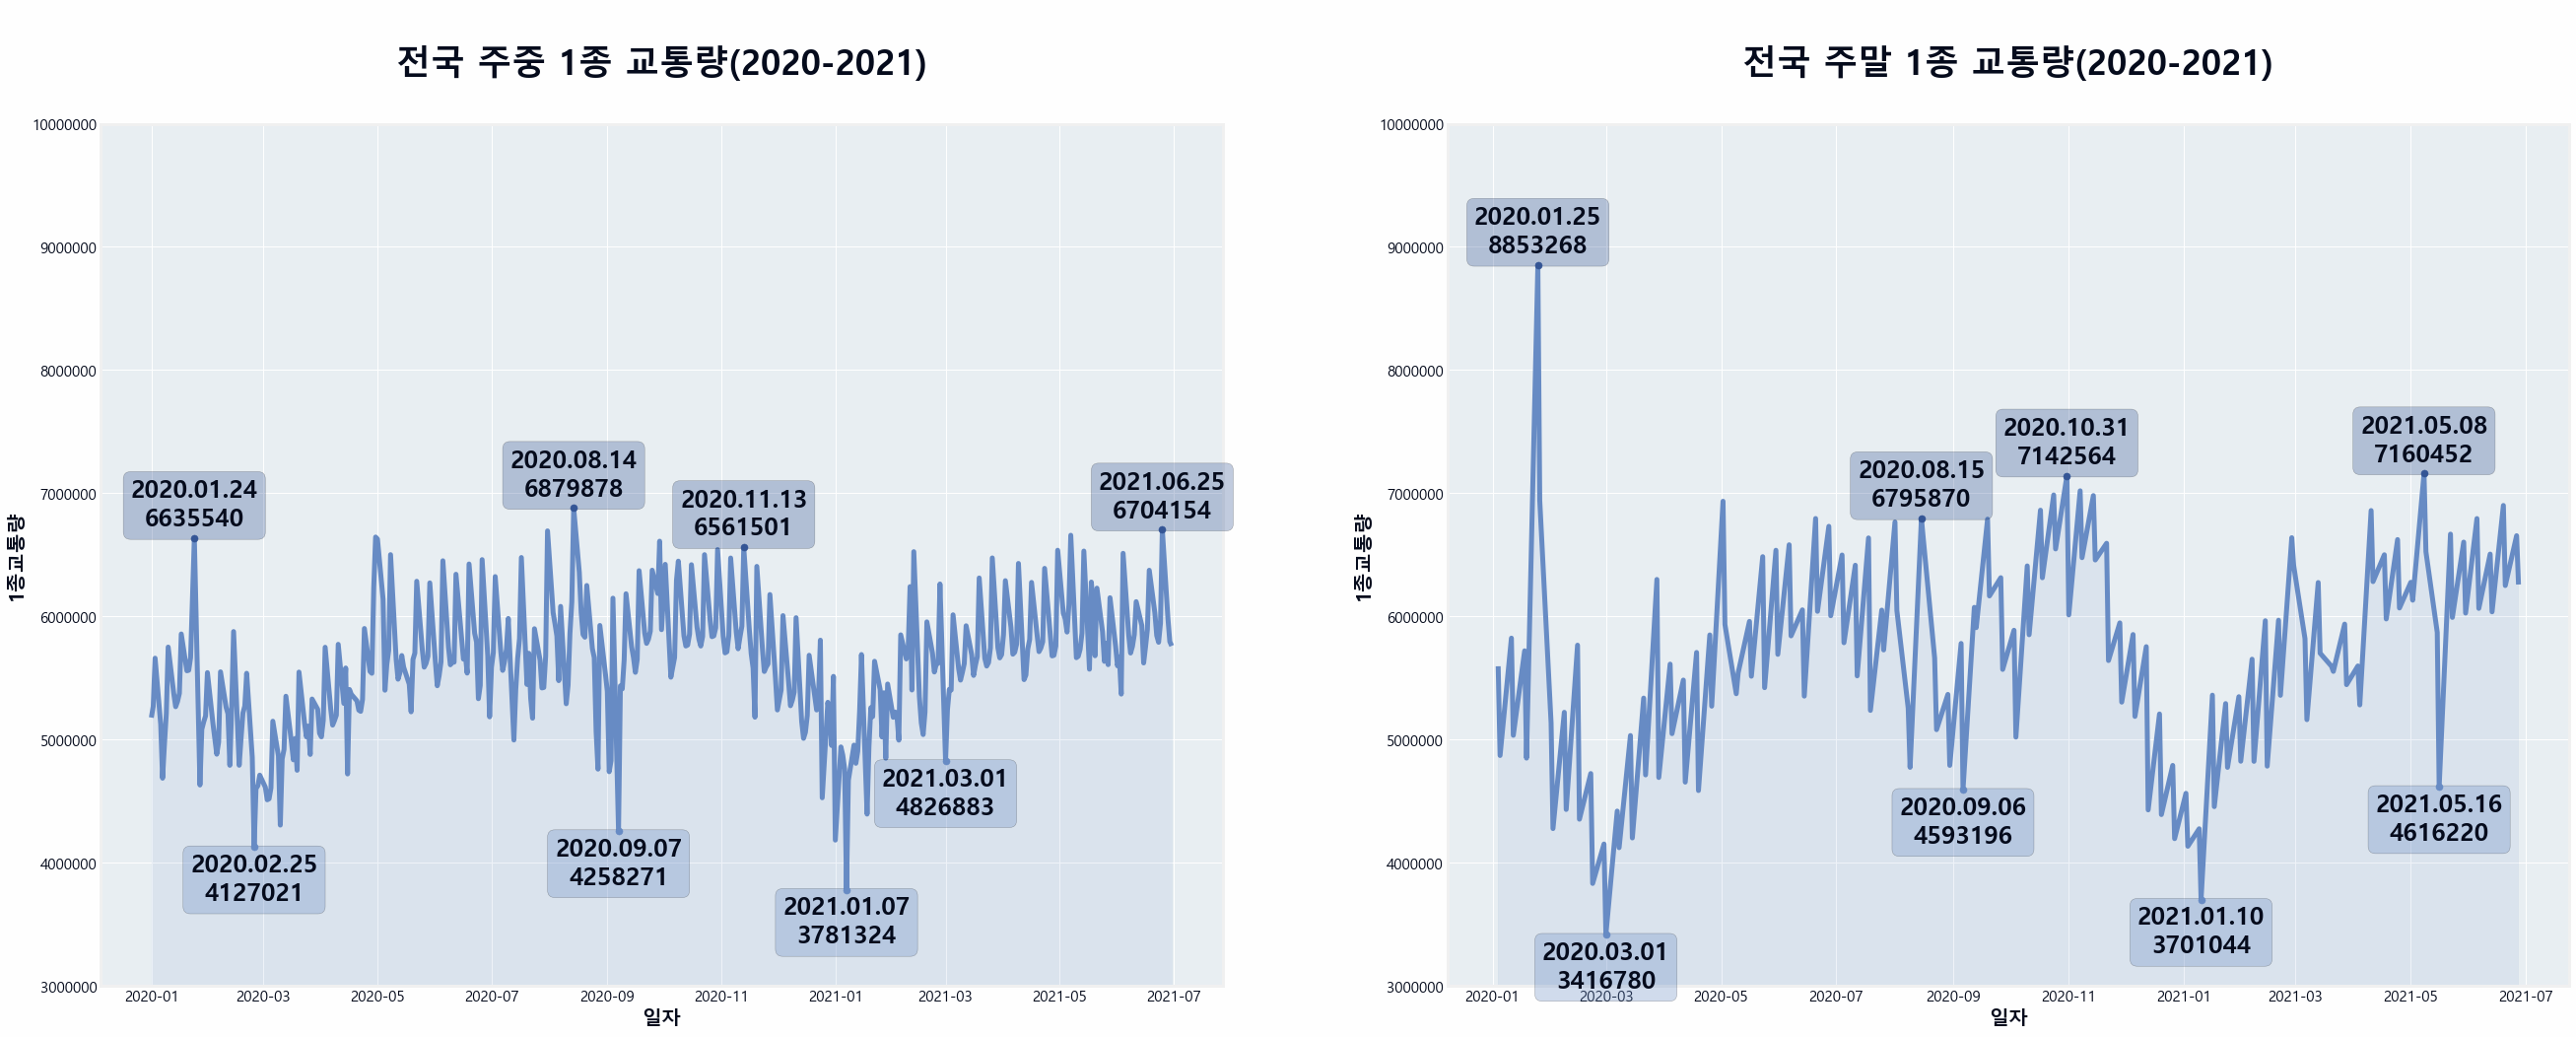

In [27]:
# 요일별 차종 평균 그래프 시각화

fig, axes=plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(40,15)
traffic_weekd=traffic_data_2020_2021[((traffic_data_total.요일=='월요일')
                                    |(traffic_data_total.요일=='화요일')
                                    |(traffic_data_total.요일=='수요일')
                                    |(traffic_data_total.요일=='목요일')
                                    |(traffic_data_total.요일=='금요일'))
                                    &((traffic_data_total.년도==2020)|(traffic_data_total.년도==2021))]
traffic_weeke=traffic_data_2020_2021[((traffic_data_total.요일=='토요일')
                                    |(traffic_data_total.요일=='일요일'))
                                    &((traffic_data_total.년도==2020)|(traffic_data_total.년도==2021))]
x1=traffic_weekd.index
y1=traffic_weekd['1종교통량']

x2=traffic_weeke.index
y2=traffic_weeke['1종교통량']
x=[x1, x2]
y=[y1, y2]
print(len(x1))
for i in range(2):
    axes[i].get_yaxis().get_major_formatter().set_scientific(False)
    axes[i].set_ylim([3000000,10000000])
    axes[i].grid(color=ColorGrid) 
    axes[i].tick_params(axis='x', labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)
    axes[i].set_xlabel('일자',fontsize=20,weight='bold')
    axes[i].set_ylabel('1종교통량',fontsize=20,weight='bold')


    li=q(len(x[i]))
    axes[i]=pointing(x[i],y[i],[li[0],li[1]-20],axes[i],True,50000,25)
    axes[i]=pointing(x[i],y[i],[li[0],li[1]-20],axes[i],False,50000,25)
    
    axes[i]=pointing(x[i],y[i],[li[2],li[3]],axes[i],True,50000,25)
    axes[i]=pointing(x[i],y[i],[li[2],li[3]],axes[i],False,50000,25)
    
    axes[i]=pointing(x[i],y[i],[li[4],li[5]],axes[i],True,50000,25)
    axes[i]=pointing(x[i],y[i],[li[4],li[5]],axes[i],False,50000,25)
    
    axes[i]=pointing(x[i],y[i],[li[6],li[7]],axes[i],True,50000,25)
    axes[i]=pointing(x[i],y[i],[li[6],li[7]],axes[i],False,50000,25)
axes[0].set_title('\n전국 주중 1종 교통량(2020-2021)\n', weight='bold', size=35)
axes[1].set_title('\n전국 주말 1종 교통량(2020-2021)\n', weight='bold', size=35)

fill_under(sns.lineplot(data=traffic_weekd ,x='집계일자', y='1종교통량', ax=axes[0],linewidth='5',color=ColorLine1))
fill_under(sns.lineplot(data=traffic_weeke, x='집계일자', y='1종교통량', ax=axes[1],linewidth='5',color=ColorLine1))

<AxesSubplot:title={'center':'\n일요일 1종 교통량(2020-2021)\n'}, xlabel='일자', ylabel='1종교통량'>

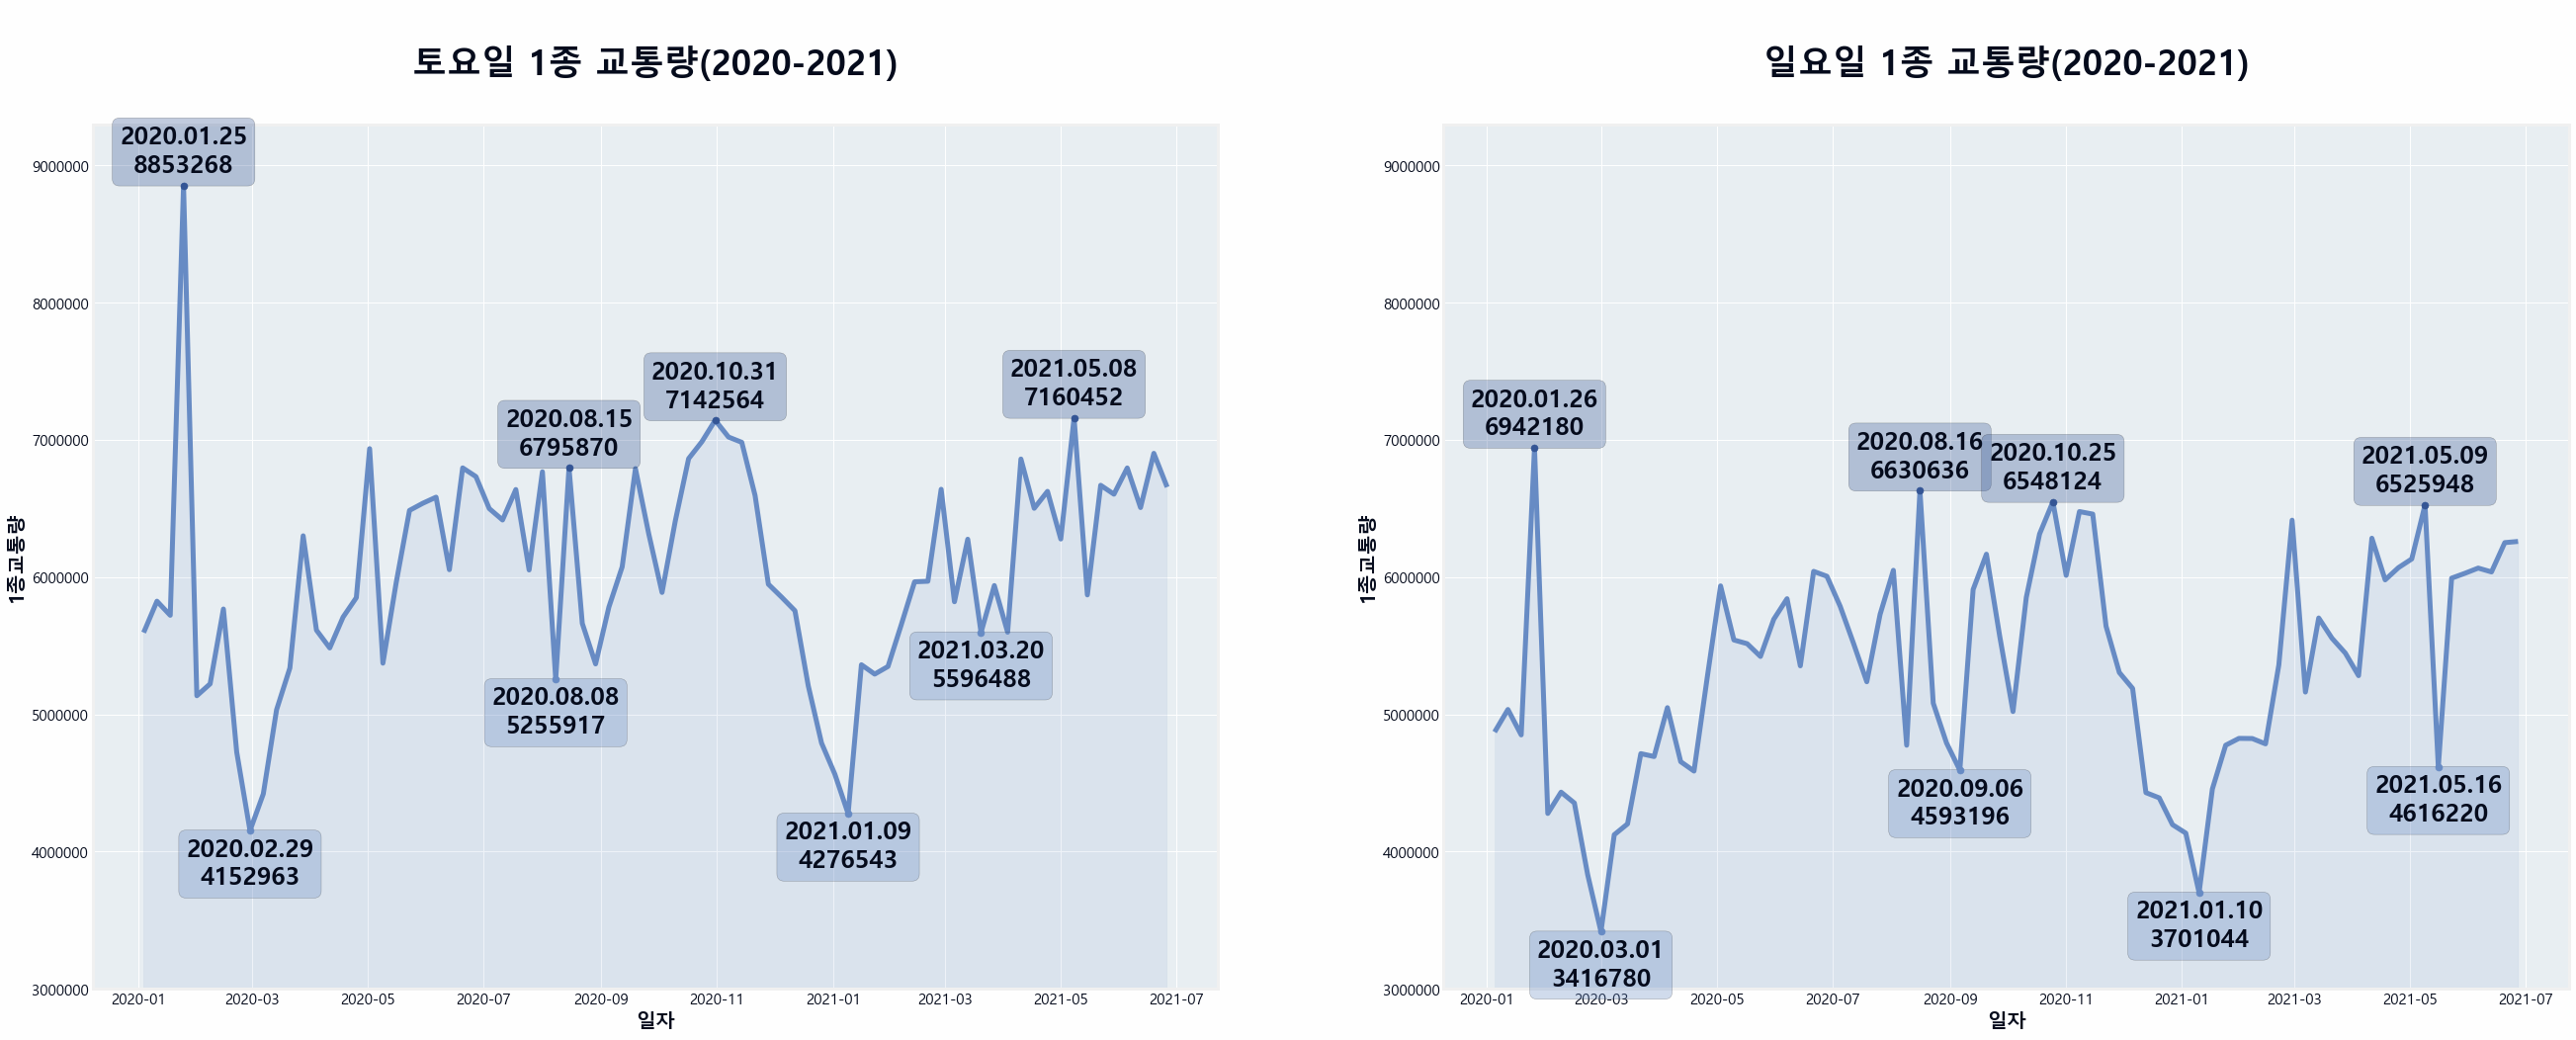

In [28]:
# 요일별 차종 평균 그래프 시각화

fig, axes=plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(40,15)

x1=traffic_data_2020_2021[(traffic_data_total.요일=='토요일')].index
y1=traffic_data_2020_2021[(traffic_data_total.요일=='토요일')]['1종교통량']

x2=traffic_data_2020_2021[(traffic_data_total.요일=='일요일')].index
y2=traffic_data_2020_2021[(traffic_data_total.요일=='일요일')]['1종교통량']
x=[x1, x2]
y=[y1, y2]

for i in range(2):
    axes[i].get_yaxis().get_major_formatter().set_scientific(False)
    axes[i].set_ylim([3000000,9300000])
    axes[i].grid(color=ColorGrid) 
    
    axes[i]=pointing(x[i],y[i],[0,20],axes[i],True,50000,25)
    axes[i]=pointing(x[i],y[i],[0,20],axes[i],False,50000,25)
    
    axes[i]=pointing(x[i],y[i],[20,40],axes[i],True,50000,25)
    axes[i]=pointing(x[i],y[i],[20,40],axes[i],False,50000,25)
    
    axes[i]=pointing(x[i],y[i],[40,60],axes[i],True,50000,25)
    axes[i]=pointing(x[i],y[i],[40,60],axes[i],False,50000,25)
    
    axes[i]=pointing(x[i],y[i],[60,78],axes[i],True,50000,25)
    axes[i]=pointing(x[i],y[i],[60,78],axes[i],False,50000,25)
    
    axes[i].tick_params(axis='x', labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)
    axes[i].set_xlabel('일자',fontsize=20,weight='bold')
    axes[i].set_ylabel('1종교통량',fontsize=20,weight='bold')

    
axes[0].set_title('\n토요일 1종 교통량(2020-2021)\n', weight='bold', size=35)
axes[1].set_title('\n일요일 1종 교통량(2020-2021)\n', weight='bold', size=35)

fill_under(sns.lineplot(data=traffic_data_2020_2021[(traffic_data_total.요일=='토요일')], x='집계일자', y='1종교통량', ax=axes[0],linewidth='5',color=ColorLine1))
fill_under(sns.lineplot(data=traffic_data_2020_2021[(traffic_data_total.요일=='일요일')], x='집계일자', y='1종교통량', ax=axes[1],linewidth='5',color=ColorLine1))


### 전국 교통량 추이 확인 - 2종 교통량

<AxesSubplot:title={'center':'\n<일요일 2종 교통량(2020-2021)>\n'}, xlabel='일자', ylabel='2종교통량'>

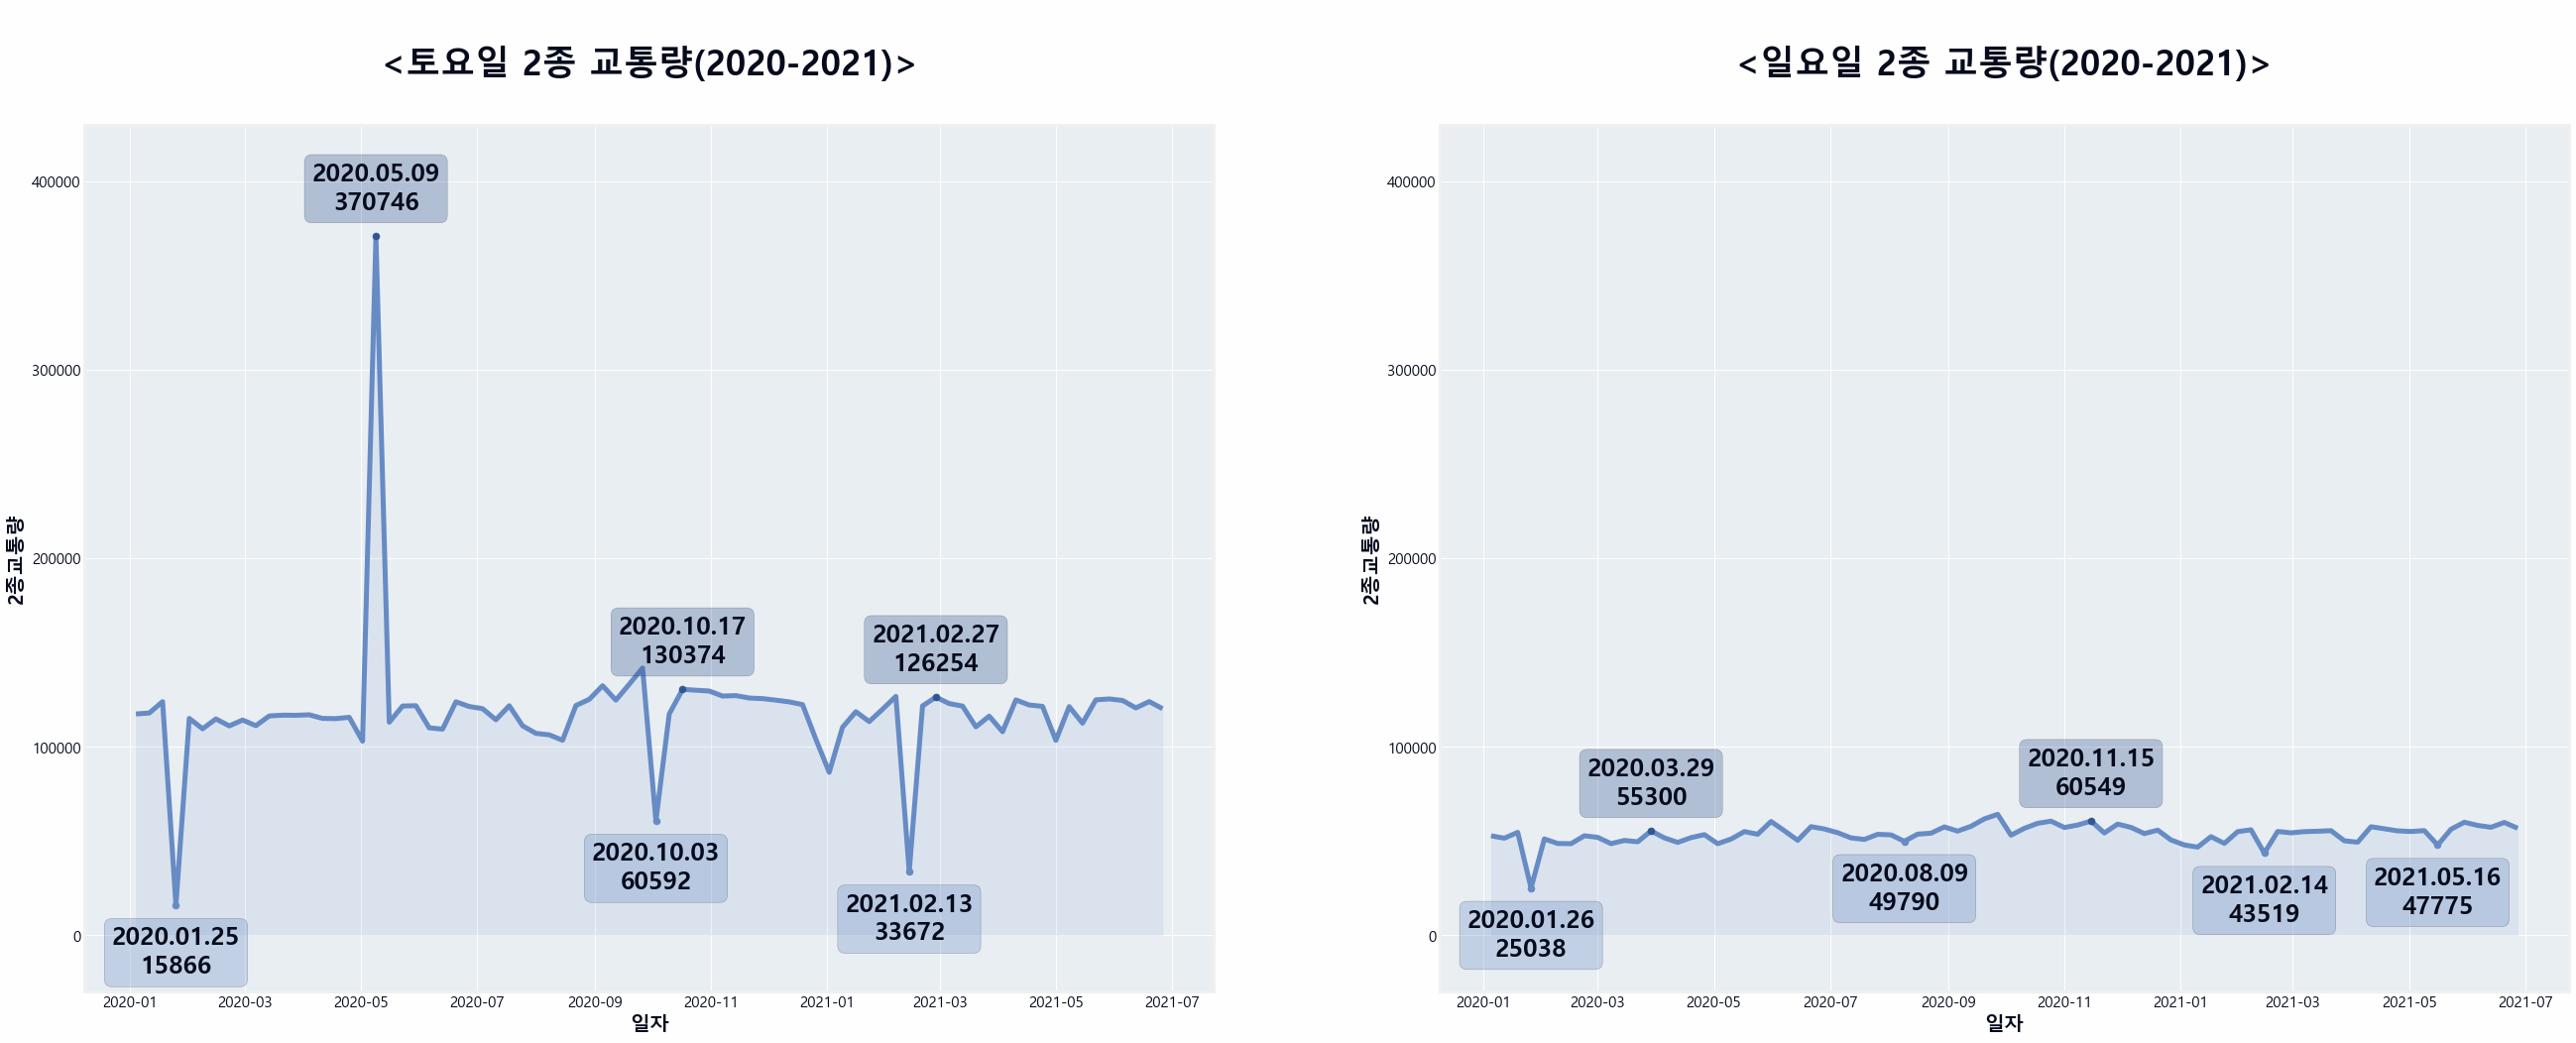

In [29]:
# 요일별 차종 평균 그래프 시각화

fig, axes=plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(40,15)

x1=traffic_data_2020_2021[(traffic_data_total.요일=='토요일')].index
y1=traffic_data_2020_2021[(traffic_data_total.요일=='토요일')]['2종교통량']

x2=traffic_data_2020_2021[(traffic_data_total.요일=='일요일')].index
y2=traffic_data_2020_2021[(traffic_data_total.요일=='일요일')]['2종교통량']
x=[x1, x2]
y=[y1, y2]

for i in range(2):
    axes[i].get_yaxis().get_major_formatter().set_scientific(False)
    axes[i].set_ylim([-30000,430000])
    axes[i].grid(color=ColorGrid) 
    
    axes[i]=pointing(x[i],y[i],[0,20],axes[i],True,11000,25)
    axes[i]=pointing(x[i],y[i],[0,20],axes[i],False,11000,25)
    
    axes[i]=pointing(x[i],y[i],[20,40],axes[i],False,11000,25)
    
    axes[i]=pointing(x[i],y[i],[40,60],axes[i],True,11000,25)
    axes[i]=pointing(x[i],y[i],[40,60],axes[i],False,11000,25)
    
    axes[i].tick_params(axis='x', labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)
    axes[i].set_xlabel('일자',fontsize=20,weight='bold')
    axes[i].set_ylabel('2종교통량',fontsize=20,weight='bold')
    
axes[0]=pointing(x[0],y[0],[60,78],axes[0],True,11000,25)
axes[1]=pointing(x[1],y[1],[60,78],axes[1],False,11000,25)
    
axes[0].set_title('\n<토요일 2종 교통량(2020-2021)>\n', size=35, weight='bold')
axes[1].set_title('\n<일요일 2종 교통량(2020-2021)>\n', size=35, weight='bold')

fill_under(sns.lineplot(data=traffic_data_2020_2021[(traffic_data_total.요일=='토요일')], x='집계일자', y='2종교통량', ax=axes[0],linewidth='5',color=ColorLine1))
fill_under(sns.lineplot(data=traffic_data_2020_2021[(traffic_data_total.요일=='일요일')], x='집계일자', y='2종교통량', ax=axes[1],linewidth='5',color=ColorLine1))

## 서울 교통량 분석

In [30]:
seoul_traffic_data=traffic_data[(traffic_data['영업소명']=='서서울')|(traffic_data['영업소명']=='동서울')|(traffic_data['영업소명']=='서울')]
seoul_traffic_data=seoul_traffic_data.groupby('집계일자')['1종교통량', '2종교통량','3종교통량', '4종교통량', '5종교통량', '6종교통량', '총교통량'].sum()
seoul_traffic_data=day_of_week(seoul_traffic_data)
#[서울]1종교통량, 2종교통량 최소 최대값 구하기

seoul_min_first=min(seoul_traffic_data['1종교통량'])
seoul_max_first=max(seoul_traffic_data['1종교통량'])

seoul_min_second=min(seoul_traffic_data['2종교통량'])
seoul_max_second=max(seoul_traffic_data['2종교통량'])

seoul_traffic_data.head()

,1종교통량,2종교통량,3종교통량,4종교통량,5종교통량,6종교통량,총교통량,년도,월,요일
집계일자,,,,,,,,,,
2018-01-01,422993,5819,20619,2523,1392,18046,471392,2018,1,월요일
2018-01-02,412943,17056,29178,11928,9202,22481,502788,2018,1,화요일
2018-01-03,395108,20067,32127,16606,11753,22022,497683,2018,1,수요일
2018-01-04,402322,19891,32029,16087,11928,22179,504436,2018,1,목요일
2018-01-05,435052,19531,33259,15420,11579,23623,538464,2018,1,금요일


### 서울 1종 교통량

<AxesSubplot:title={'center':'\n서울 1종 교통량(2020-2021)\n'}, xlabel='일자', ylabel='1종교통량'>

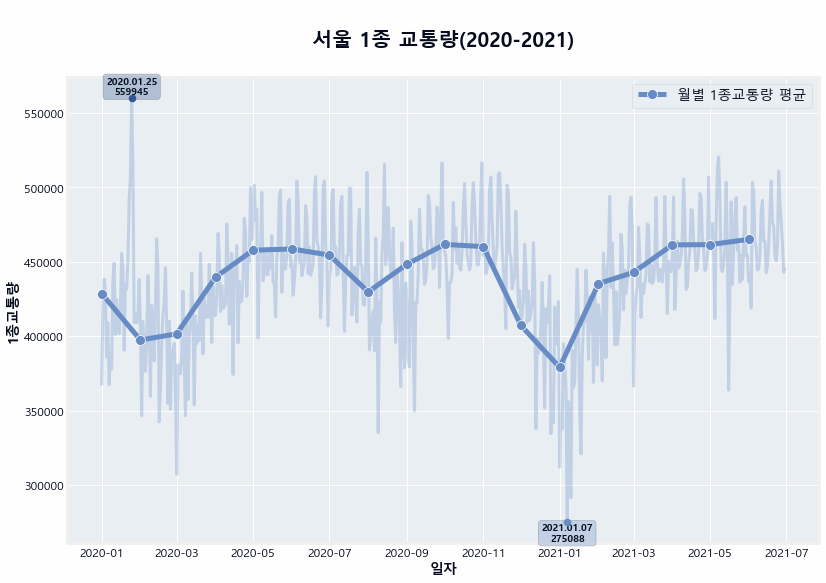

In [31]:
# 1종 교통량(대부분의 자가용) 분석 

data=pd.DataFrame(seoul_traffic_data[((seoul_traffic_data.년도==2020)|(seoul_traffic_data.년도==2021))].groupby(['년도','월'])['1종교통량'].mean())
time=[]
for i in range(len(data.index)):
    time.append(str(data.index[i][0])+'-'+str(data.index[i][1])+'-1')
data['날짜 중앙값']=time
data['날짜 중앙값']=pd.to_datetime(data['날짜 중앙값'],format='%Y-%m-%d')


plt.figure(figsize=(12,8)) 

plt.grid(color=ColorGrid) 
plt.title('\n서울 1종 교통량(2020-2021)\n', weight='bold')
plt.margins(x=0.05,y=0.05)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('일자',fontdict={'weight': 'bold', 'size': 14})
plt.ylabel('1종교통량',fontdict={'weight': 'bold', 'size': 14})
ax=plt.gca()
ax=pointing(seoul_traffic_data[(seoul_traffic_data.년도==2020)|(seoul_traffic_data.년도==2021)].index,seoul_traffic_data[(seoul_traffic_data.년도==2020)|(seoul_traffic_data.년도==2021)]['1종교통량'],[0,78],ax,True,1000,10)
ax=pointing(seoul_traffic_data[(seoul_traffic_data.년도==2020)|(seoul_traffic_data.년도==2021)].index,seoul_traffic_data[(seoul_traffic_data.년도==2020)|(seoul_traffic_data.년도==2021)]['1종교통량'],[0,-1],ax,False,1000,10)

sns.lineplot(data=seoul_traffic_data[((seoul_traffic_data.년도==2020)|(seoul_traffic_data.년도==2021))], x='집계일자', y='1종교통량',color=ColorLine1, alpha=0.3, linewidth='3')
sns.lineplot(data=data, x='날짜 중앙값', y='1종교통량',color=ColorLine1,linewidth='5',marker='o',markersize=10,label='월별 1종교통량 평균')

교통량이 갑자기 줄어드는 시기가 눈에 보이지만, 주중과 주말의 교통량 극심한 차이로 인하여 그래프 상에서 진동이 심하게 일어난다. 따라서 주말만 비교해 보자.

<AxesSubplot:title={'center':'\n서울 주말 1종 교통량(2020-2021)\n'}, xlabel='일자', ylabel='1종교통량'>

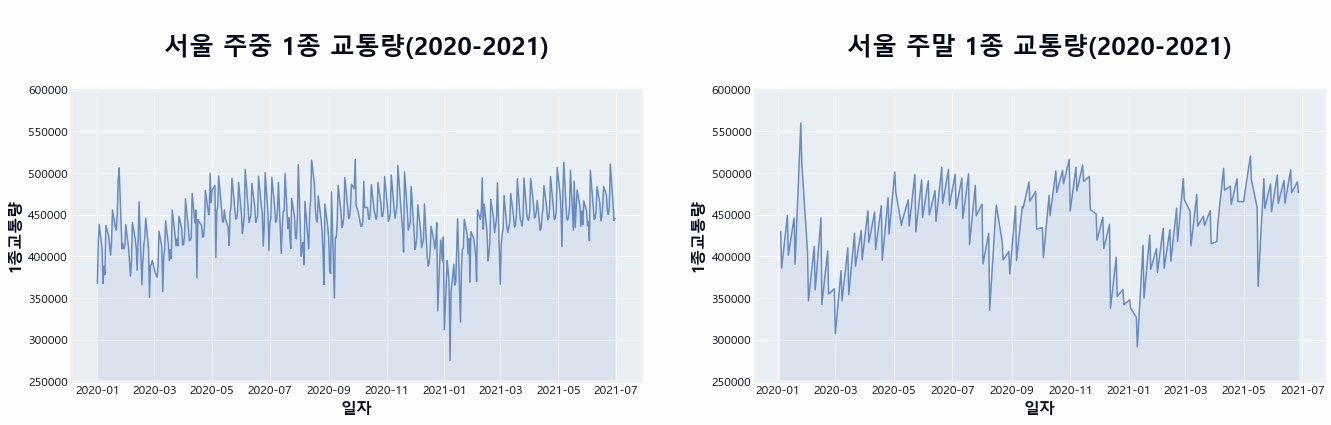

In [32]:
# 주중/ 주말 차종 평균 그래프 시각화

fig, axes=plt.subplots(ncols=2)
fig.set_size_inches(20,5)

for i in range(2):
    axes[i].get_yaxis().get_major_formatter().set_scientific(False)
    axes[i].set_ylim([250000,600000])
    axes[i].grid(color=ColorGrid) 
    
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].set_xlabel('일자',fontsize=16,weight='bold')
    axes[i].set_ylabel('1종교통량',fontsize=16,weight='bold')


axes[0].set_title('\n서울 주중 1종 교통량(2020-2021)\n',fontsize=25,weight='bold')
axes[1].set_title('\n서울 주말 1종 교통량(2020-2021)\n',fontsize=25,weight='bold')

fill_under(sns.lineplot(data=seoul_traffic_data[((seoul_traffic_data.요일=='월요일')
                                    |(seoul_traffic_data.요일=='화요일')
                                    |(seoul_traffic_data.요일=='수요일')
                                    |(seoul_traffic_data.요일=='목요일')
                                    |(seoul_traffic_data.요일=='금요일'))
                                    &((seoul_traffic_data.년도==2020)|(seoul_traffic_data.년도==2021))], x='집계일자', y='1종교통량', ax=axes[0],color=ColorLine1, linewidth='1.5'))
fill_under(sns.lineplot(data=seoul_traffic_data[((seoul_traffic_data.요일=='토요일')|(seoul_traffic_data.요일=='일요일'))&((seoul_traffic_data.년도==2020)|(seoul_traffic_data.년도==2021))], x='집계일자', y='1종교통량', ax=axes[1],color=ColorLine1,lw=1.5))

<AxesSubplot:title={'center':'\n서울 일요일 1종 교통량(2020-2021)\n'}, xlabel='일자', ylabel='1종교통량'>

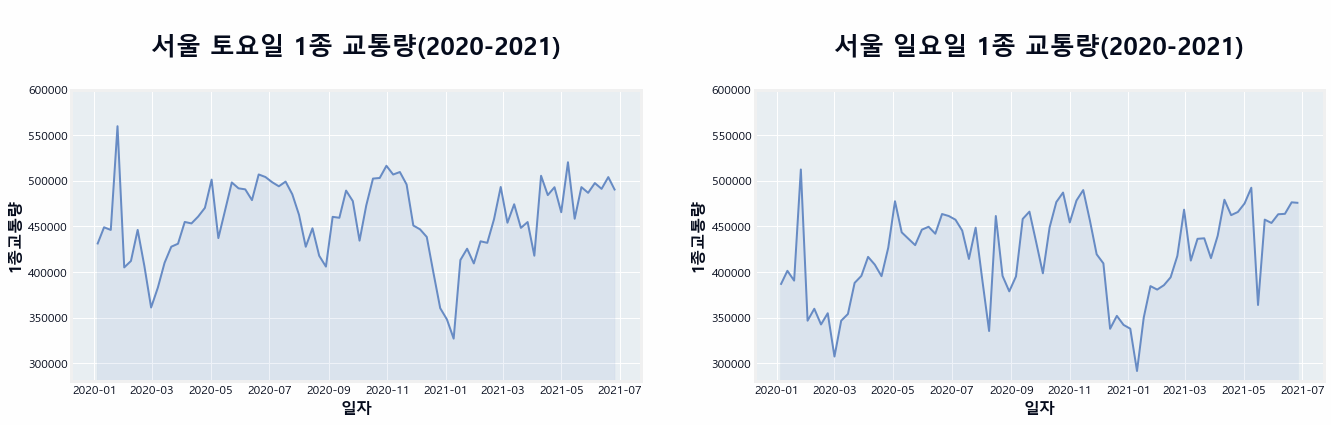

In [33]:
# 요일별 차종 평균 그래프 시각화

fig, axes=plt.subplots(ncols=2)
fig.set_size_inches(20,5)

for i in range(2):
    axes[i].get_yaxis().get_major_formatter().set_scientific(False)
    axes[i].set_ylim([280000,600000])
    axes[i].grid(color=ColorGrid) 
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].set_xlabel('일자',fontsize=16,weight='bold')
    axes[i].set_ylabel('1종교통량',fontsize=16,weight='bold')


axes[0].set_title('\n서울 토요일 1종 교통량(2020-2021)\n',fontsize=25,weight='bold')
axes[1].set_title('\n서울 일요일 1종 교통량(2020-2021)\n',fontsize=25,weight='bold')

fill_under(sns.lineplot(data=seoul_traffic_data[(seoul_traffic_data.요일=='토요일')&((seoul_traffic_data.년도==2020)|(seoul_traffic_data.년도==2021))], x='집계일자', y='1종교통량', ax=axes[0],lw=2,color=ColorLine1))
fill_under(sns.lineplot(data=seoul_traffic_data[(seoul_traffic_data.요일=='일요일')&((seoul_traffic_data.년도==2020)|(seoul_traffic_data.년도==2021))], x='집계일자', y='1종교통량', ax=axes[1],lw=2,color=ColorLine1))


### 서울 2종 교통량

자가용이 아닌 택배 차량을 확인해 보자.
쿠팡, CJ 택배와 같은 화물 차양은 2종 차량으로 분류 된다.

<AxesSubplot:title={'center':'\n서울 일요일 2종 교통량(2020-2021)\n'}, xlabel='일자', ylabel='2종교통량'>

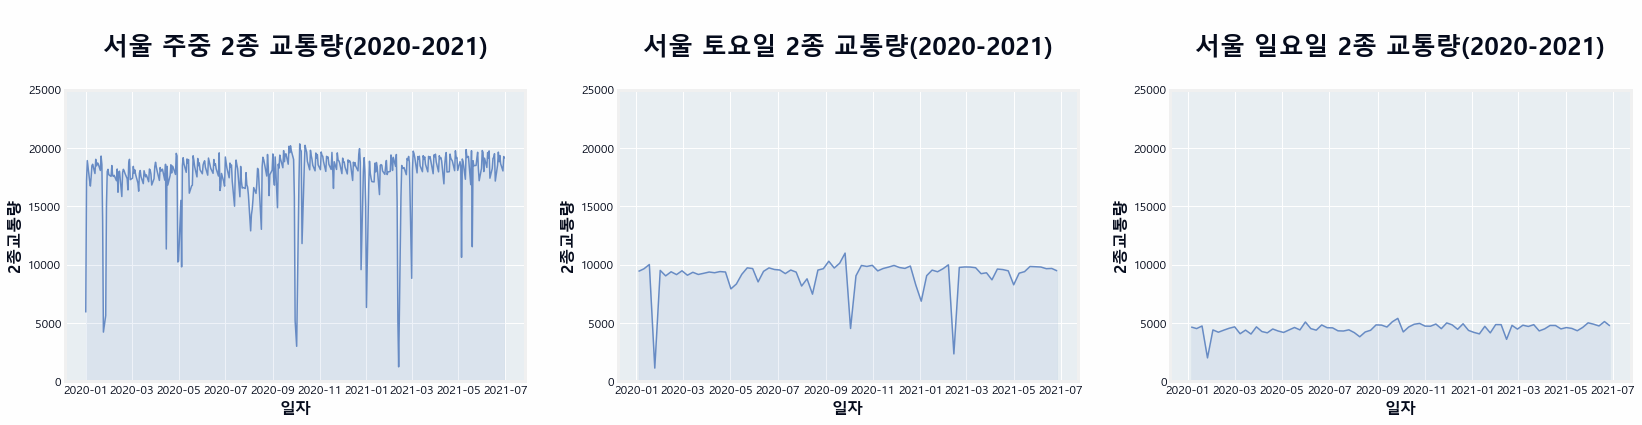

In [34]:
# 2종 교통량(중형차) 주중/ 주말 차종 평균 그래프 시각화

fig, axes=plt.subplots(ncols=3)
fig.set_size_inches(25,5)

axes[0].set_title('\n서울 주중 2종 교통량(2020-2021)\n',fontsize=25,weight='bold')
axes[1].set_title('\n서울 토요일 2종 교통량(2020-2021)\n',fontsize=25,weight='bold')
axes[2].set_title('\n서울 일요일 2종 교통량(2020-2021)\n',fontsize=25,weight='bold')

for i in range(3):
    axes[i].get_yaxis().get_major_formatter().set_scientific(False)
    axes[i].set_ylim([0,25000])
    axes[i].grid(color=ColorGrid)
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].set_xlabel('일자',fontsize=16,weight='bold')
    axes[i].set_ylabel('2종교통량',fontsize=16,weight='bold')
    
fill_under(sns.lineplot(data=seoul_traffic_data[((seoul_traffic_data.요일=='월요일')
                                    |(seoul_traffic_data.요일=='화요일')
                                    |(seoul_traffic_data.요일=='수요일')
                                    |(seoul_traffic_data.요일=='목요일')
                                    |(seoul_traffic_data.요일=='금요일'))
                                    &((seoul_traffic_data.년도==2020)|(seoul_traffic_data.년도==2021))], x='집계일자', y='2종교통량', ax=axes[0],color=ColorLine1, linewidth='1.5'))
fill_under(sns.lineplot(data=seoul_traffic_data[(seoul_traffic_data.요일=='토요일')&((seoul_traffic_data.년도==2020)|(seoul_traffic_data.년도==2021))], x='집계일자', y='2종교통량', ax=axes[1],color=ColorLine1, linewidth='1.5'))
fill_under(sns.lineplot(data=seoul_traffic_data[(seoul_traffic_data.요일=='일요일')&((seoul_traffic_data.년도==2020)|(seoul_traffic_data.년도==2021))], x='집계일자', y='2종교통량', ax=axes[2],color=ColorLine1, linewidth='1.5'))

## 대구 교통량 분석

코로나 19 1차 대유행발발 지역인 대구를 추가적으로 살펴 보자.

In [35]:
daegu_traffic_data=traffic_data[(traffic_data['영업소명']=='서대구')|(traffic_data['영업소명']=='남대구')|(traffic_data['영업소명']=='북대구')].groupby('집계일자')['1종교통량', '2종교통량','3종교통량', '4종교통량', '5종교통량', '6종교통량', '총교통량'].sum()
daegu_traffic_data=day_of_week(daegu_traffic_data)
daegu_traffic_data.head()

,1종교통량,2종교통량,3종교통량,4종교통량,5종교통량,6종교통량,총교통량,년도,월,요일
집계일자,,,,,,,,,,
2018-01-01,158432,1384,3607,712,516,5847,170498,2018,1,월요일
2018-01-02,161220,6162,7056,3431,3685,7883,189437,2018,1,화요일
2018-01-03,160008,7111,8303,4490,4598,7705,192215,2018,1,수요일
2018-01-04,161046,6983,8325,4443,4951,7736,193484,2018,1,목요일
2018-01-05,174056,7281,8340,4325,5110,8321,207433,2018,1,금요일


### 대구 1종 교통량 분석

<AxesSubplot:title={'center':'\n대구 1종 교통량(2020-2021)\n'}, xlabel='일자', ylabel='1종교통량'>

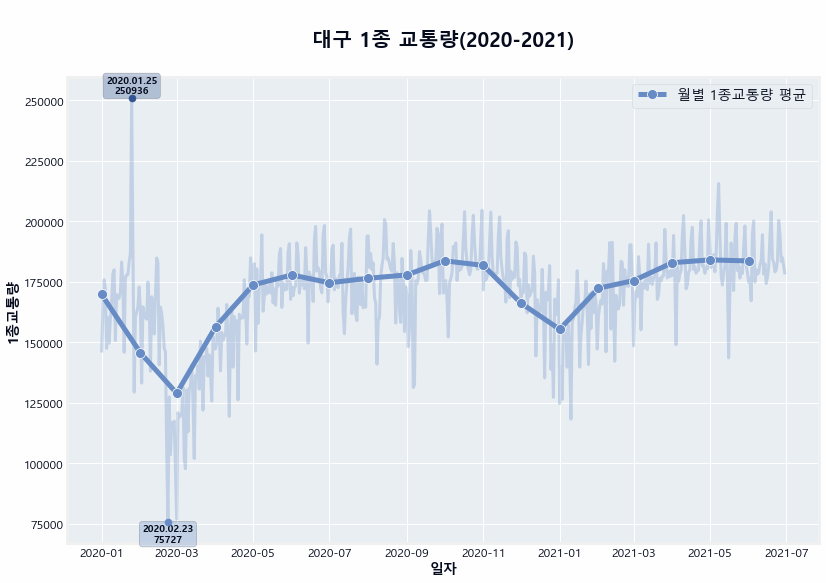

In [36]:
# 1종 교통량(대부분의 자가용) 분석 

data=pd.DataFrame(daegu_traffic_data[((daegu_traffic_data.년도==2020)|(daegu_traffic_data.년도==2021))].groupby(['년도','월'])['1종교통량'].mean())
time=[]
for i in range(len(data.index)):
    time.append(str(data.index[i][0])+'-'+str(data.index[i][1])+'-1')
data['날짜 중앙값']=time
data['날짜 중앙값']=pd.to_datetime(data['날짜 중앙값'],format='%Y-%m-%d')


plt.figure(figsize=(12,8)) 

plt.grid(color=ColorGrid) 
plt.title('\n대구 1종 교통량(2020-2021)\n', weight='bold')
plt.margins(x=0.05,y=0.05)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('일자',fontdict={'weight': 'bold', 'size': 14})
plt.ylabel('1종교통량',fontdict={'weight': 'bold', 'size': 14})
ax=plt.gca()
ax=pointing(daegu_traffic_data[(daegu_traffic_data.년도==2020)|(daegu_traffic_data.년도==2021)].index,daegu_traffic_data[(daegu_traffic_data.년도==2020)|(daegu_traffic_data.년도==2021)]['1종교통량'],[0,78],ax,True,1000,10)
ax=pointing(daegu_traffic_data[(daegu_traffic_data.년도==2020)|(daegu_traffic_data.년도==2021)].index,daegu_traffic_data[(daegu_traffic_data.년도==2020)|(daegu_traffic_data.년도==2021)]['1종교통량'],[0,-1],ax,False,1000,10)

sns.lineplot(data=daegu_traffic_data[((daegu_traffic_data.년도==2020)|(daegu_traffic_data.년도==2021))], x='집계일자', y='1종교통량',color=ColorLine1, alpha=0.3, linewidth='3')
sns.lineplot(data=data, x='날짜 중앙값', y='1종교통량',color=ColorLine1,linewidth='5',marker='o',markersize=10,label='월별 1종교통량 평균')

<AxesSubplot:title={'center':'\n대구 주말 1종 교통량(2020-2021)\n'}, xlabel='일자', ylabel='1종교통량'>

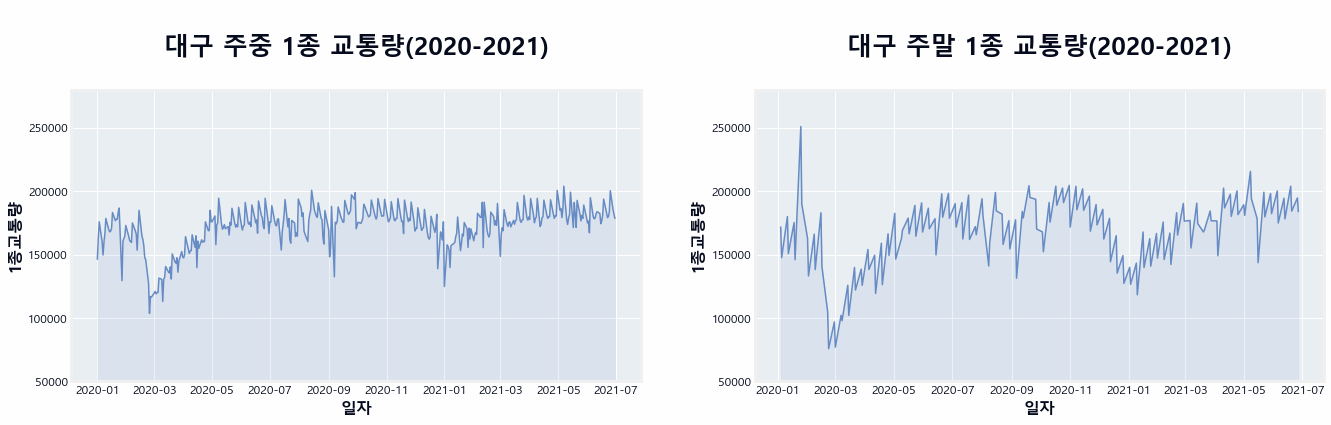

In [37]:
# 주중/ 주말 차종 평균 그래프 시각화

fig, axes=plt.subplots(ncols=2)
fig.set_size_inches(20,5)

for i in range(2):
    axes[i].get_yaxis().get_major_formatter().set_scientific(False)
    axes[i].set_ylim([50000,280000])
    axes[i].grid(color=ColorGrid) 
    
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].set_xlabel('일자',fontsize=16,weight='bold')
    axes[i].set_ylabel('1종교통량',fontsize=16,weight='bold')


axes[0].set_title('\n대구 주중 1종 교통량(2020-2021)\n',fontsize=25,weight='bold')
axes[1].set_title('\n대구 주말 1종 교통량(2020-2021)\n',fontsize=25,weight='bold')

fill_under(sns.lineplot(data=daegu_traffic_data[((daegu_traffic_data.요일=='월요일')
                                    |(daegu_traffic_data.요일=='화요일')
                                    |(daegu_traffic_data.요일=='수요일')
                                    |(daegu_traffic_data.요일=='목요일')
                                    |(daegu_traffic_data.요일=='금요일'))
                                    &((daegu_traffic_data.년도==2020)|(daegu_traffic_data.년도==2021))], x='집계일자', y='1종교통량', ax=axes[0],color=ColorLine1, linewidth='1.5'))
fill_under(sns.lineplot(data=daegu_traffic_data[((daegu_traffic_data.요일=='토요일')|(daegu_traffic_data.요일=='일요일'))&((daegu_traffic_data.년도==2020)|(daegu_traffic_data.년도==2021))], x='집계일자', y='1종교통량', ax=axes[1],color=ColorLine1,lw=1.5))

<AxesSubplot:title={'center':'\n대구 일요일 1종 교통량(2020-2021)\n'}, xlabel='일자', ylabel='1종교통량'>

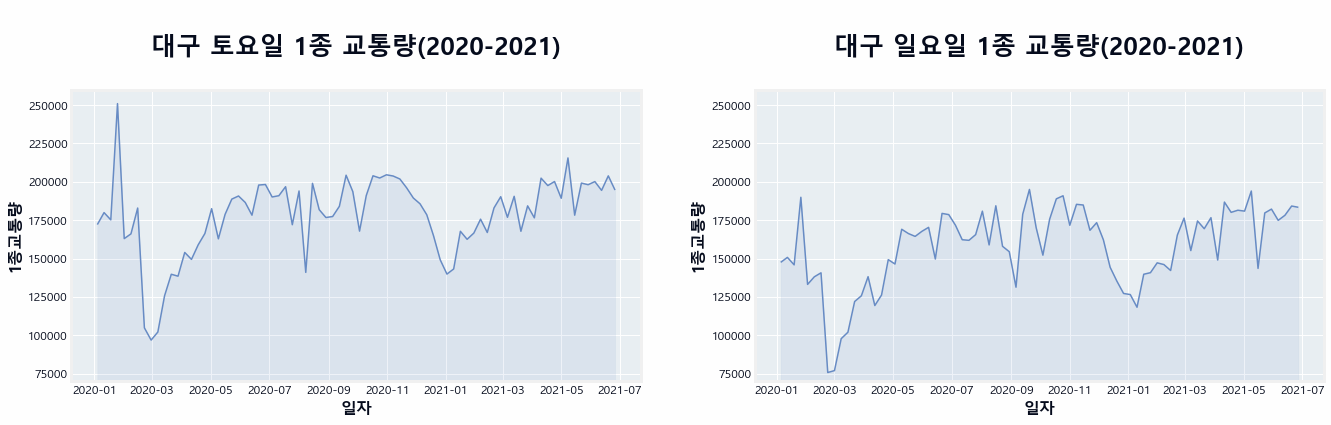

In [38]:
# 1종 교통량(중형차) 주중/ 주말 차종 평균 그래프 시각화

fig, axes=plt.subplots(ncols=2)
fig.set_size_inches(20,5)


axes[0].set_title('\n대구 토요일 1종 교통량(2020-2021)\n', fontsize=25, weight='bold')
axes[1].set_title('\n대구 일요일 1종 교통량(2020-2021)\n', fontsize=25, weight='bold')

for i in range(2):
    axes[i].get_yaxis().get_major_formatter().set_scientific(False)
    axes[i].set_ylim([70000,260000])
    axes[i].grid(color=ColorGrid)
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].set_xlabel('일자',fontsize=16,weight='bold')
    axes[i].set_ylabel('1종교통량',fontsize=16,weight='bold')
    
fill_under(sns.lineplot(data=daegu_traffic_data[(daegu_traffic_data.요일=='토요일')&((daegu_traffic_data.년도==2020)|(daegu_traffic_data.년도==2021))], x='집계일자', y='1종교통량', ax=axes[0],color=ColorLine1, linewidth='1.5'))
fill_under(sns.lineplot(data=daegu_traffic_data[(daegu_traffic_data.요일=='일요일')&((daegu_traffic_data.년도==2020)|(daegu_traffic_data.년도==2021))], x='집계일자', y='1종교통량', ax=axes[1],color=ColorLine1, linewidth='1.5'))

### 대구 2종 교통량 분석

<AxesSubplot:title={'center':'\n대구 일요일 2종 교통량(2020-2021)\n'}, xlabel='일자', ylabel='2종교통량'>

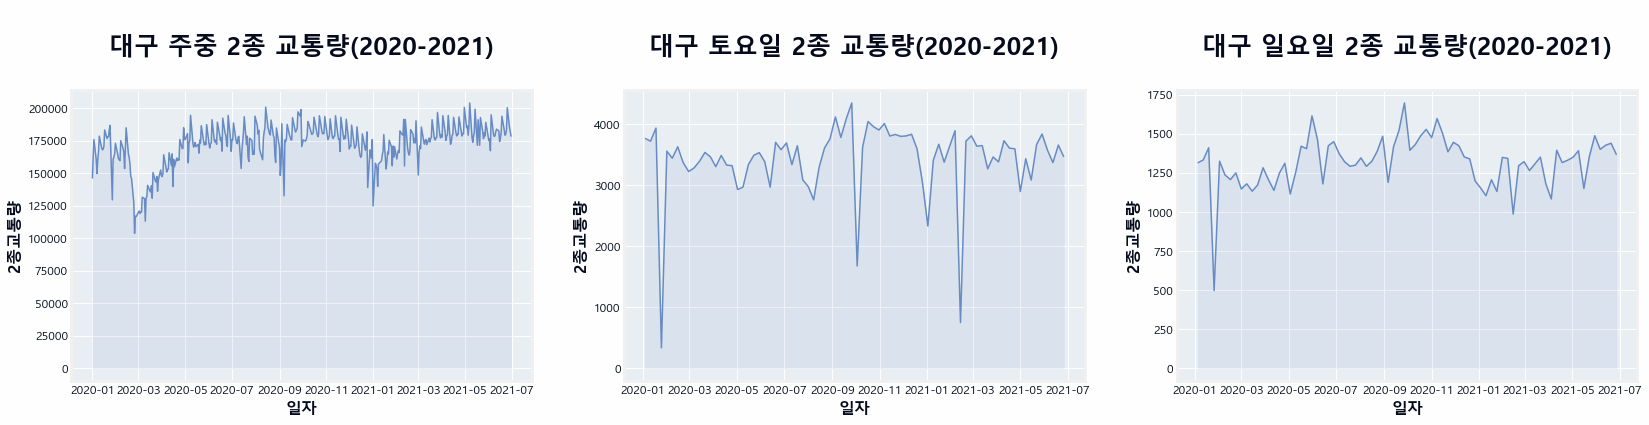

In [39]:
# 1종 교통량(중형차) 주중/ 주말 차종 평균 그래프 시각화

fig, axes=plt.subplots(ncols=3)
fig.set_size_inches(25,5)

axes[0].set_title('\n대구 주중 2종 교통량(2020-2021)\n', fontsize=25, weight='bold')
axes[1].set_title('\n대구 토요일 2종 교통량(2020-2021)\n', fontsize=25, weight='bold')
axes[2].set_title('\n대구 일요일 2종 교통량(2020-2021)\n', fontsize=25, weight='bold')

for i in range(3):
    axes[i].get_yaxis().get_major_formatter().set_scientific(False)
    axes[i].grid(color=ColorGrid)
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].set_xlabel('일자',fontsize=16,weight='bold')
    axes[i].set_ylabel('2종교통량',fontsize=16,weight='bold')
    
fill_under(sns.lineplot(data=daegu_traffic_data[((daegu_traffic_data.요일=='월요일')
                                    |(daegu_traffic_data.요일=='화요일')
                                    |(daegu_traffic_data.요일=='수요일')
                                    |(daegu_traffic_data.요일=='목요일')
                                    |(daegu_traffic_data.요일=='금요일'))
                                    &((daegu_traffic_data.년도==2020)|(daegu_traffic_data.년도==2021))], x='집계일자', y='1종교통량', ax=axes[0],color=ColorLine1, linewidth='1.5'))
fill_under(sns.lineplot(data=daegu_traffic_data[(daegu_traffic_data.요일=='토요일')&((daegu_traffic_data.년도==2020)|(daegu_traffic_data.년도==2021))], x='집계일자', y='2종교통량', ax=axes[1],color=ColorLine1, linewidth='1.5'))
fill_under(sns.lineplot(data=daegu_traffic_data[(daegu_traffic_data.요일=='일요일')&((daegu_traffic_data.년도==2020)|(daegu_traffic_data.년도==2021))], x='집계일자', y='2종교통량', ax=axes[2],color=ColorLine1, linewidth='1.5'))

# 코로나 확진자 VS 교통량

전국적으로 또는 지역별로 코로나 확진자 수와 교통량의 관계를 확인해보자

In [40]:
covid_traffic=covid_data_new.join(traffic_data_total['1종교통량'],how='inner')
covid_traffic['일자']=covid_traffic.index
covid_traffic.head()

,일별확진자,누적확진자,누적사망자,년도,월,1종교통량,일자
2021-06-30,761.0,156960,2018.0,2021,6,5761122,2021-06-30
2021-06-29,794.0,156166,2017.0,2021,6,5795714,2021-06-29
2021-06-28,595.0,155571,2015.0,2021,6,5983959,2021-06-28
2021-06-27,501.0,155070,2013.0,2021,6,6259574,2021-06-27
2021-06-26,614.0,154456,2012.0,2021,6,6655649,2021-06-26


<AxesSubplot:title={'center':'\n교통량(1종) VS COVID19 확진자\n'}, xlabel='일자', ylabel='1종교통량'>

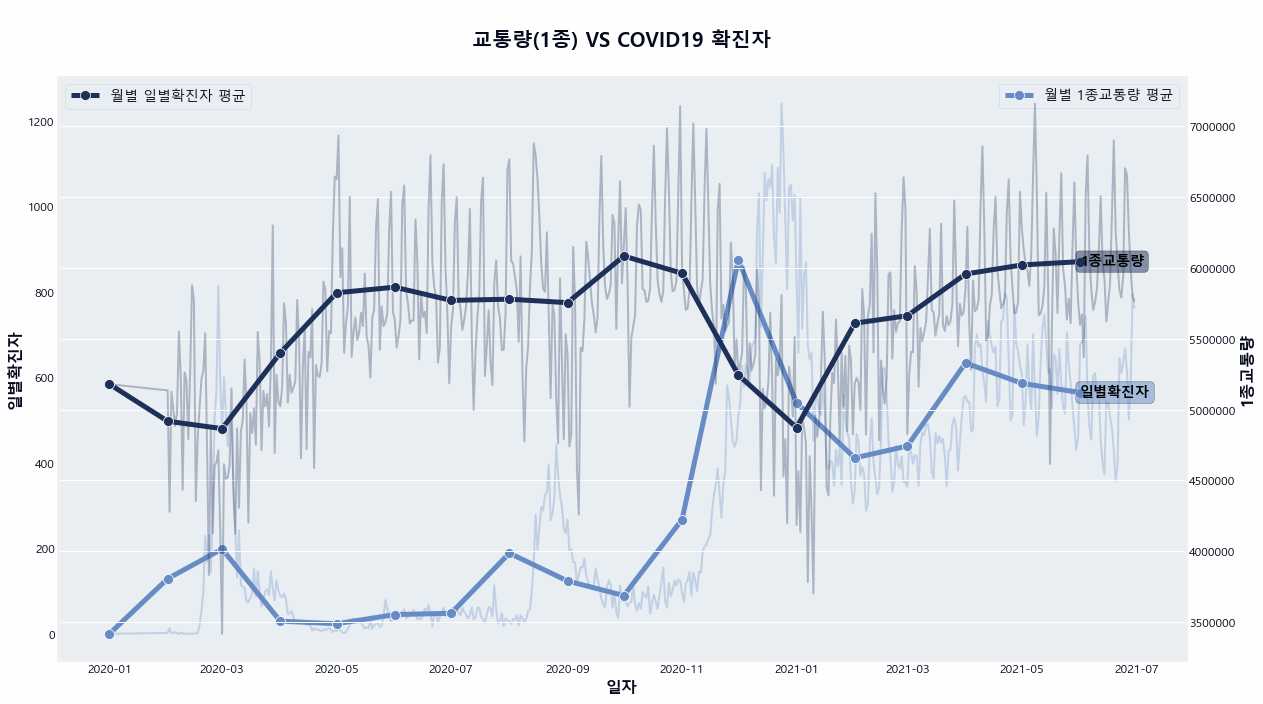

In [41]:
data1=pd.DataFrame(covid_traffic[((covid_traffic.년도==2020)|(covid_traffic.년도==2021))].groupby(['년도','월'])['일별확진자'].mean())
data2=pd.DataFrame(covid_traffic[((covid_traffic.년도==2020)|(covid_traffic.년도==2021))].groupby(['년도','월'])['1종교통량'].mean())
time=[]
for i in range(len(data.index)):
    time.append(str(data.index[i][0])+'-'+str(data.index[i][1])+'-15')
data1['날짜 중앙값']=time
data1['날짜 중앙값']=pd.to_datetime(data['날짜 중앙값'],format='%Y-%m-%d')
data2['날짜 중앙값']=time
data2['날짜 중앙값']=pd.to_datetime(data['날짜 중앙값'],format='%Y-%m-%d')

fig, ax1=plt.subplots(figsize=(18,10))
ax2=ax1.twinx()
ax1.grid(False)
ax2.get_yaxis().get_major_formatter().set_scientific(False)
ax2.grid(color=ColorGrid)

ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax1.set_xlabel('일자',fontsize=16,weight='bold')
ax1.set_ylabel('일별확진자',fontsize=16,weight='bold')
ax2.tick_params(axis='y', labelsize=12)
ax2.set_ylabel('1종교통량',fontsize=16,weight='bold')


plt.title('\n교통량(1종) VS COVID19 확진자\n', weight='bold')

x1=list(data1['날짜 중앙값'])
y1=list(data1['일별확진자'])

x2=list(data2['날짜 중앙값'])
y2=list(data2['1종교통량'])

ax1.text(x1[-1], y1[-1], s='일별확진자', fontweight='bold',
         va='center', ha='left', color='black',  
         bbox=dict(boxstyle='round,pad=0.3', fc=ColorLine1, ec='black', alpha=0.5))

ax2.text(x2[-1], y2[-1], s='1종교통량', fontweight='bold',
         va='center', ha='left', color='black',
         bbox=dict(boxstyle='round,pad=0.3', fc=ColorLine2, ec='black', alpha=0.5))

sns.lineplot(x='일자', y='일별확진자',data=covid_traffic,color=ColorLine1, ax=ax1,alpha=0.3, linewidth='2')
sns.lineplot(x='일자', y='1종교통량',data=covid_traffic, ax=ax2, color=ColorLine2,alpha=0.3, linewidth='2')
sns.lineplot(x='날짜 중앙값', y='일별확진자',data=data1,color=ColorLine1, ax=ax1,marker='o',linewidth='5', markersize=10, label='월별 1종교통량 평균')
sns.lineplot(x='날짜 중앙값', y='1종교통량',data=data2, ax=ax2, color=ColorLine2 ,marker='o',linewidth='5', markersize=10, label='월별 일별확진자 평균')

## 확진자 수의 단위별 교통량 분석

Text(0.5, 1.1, '\n일별확진자와 1종교통량의 RegPlot\n')

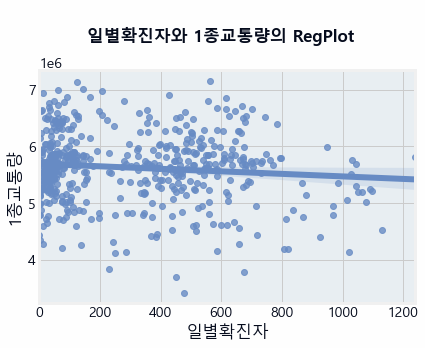

In [42]:
sns.regplot(data=covid_traffic, x='일별확진자', y='1종교통량',color=ColorLine1)
plt.suptitle('\n일별확진자와 1종교통량의 RegPlot\n', y=1.1, weight='bold')


## 연휴철 교통량 및 확진자 수 분석

1월(연초행사), 2월(설), 5월(어린이날) 중심으로 분석

### 1분기(1월, 2월) 분석

In [43]:
#1분기 데이터 합치기
fitst_traffic_data=pd.concat([traffic_2020_01,traffic_2021_01])

In [44]:
#1분기데이터 년도, 월 칼럼추가
fitst_traffic_data.index=fitst_traffic_data.집계일자
fitst_traffic_data=fitst_traffic_data.drop('집계일자',axis=1)
fitst_traffic_data=fitst_traffic_data[['영업소명','1종교통량', '2종교통량','3종교통량', '4종교통량', '5종교통량', '6종교통량', '총교통량']]
fitst_traffic_data=day_of_week(fitst_traffic_data)

In [45]:
fitst_traffic_data.head()

,영업소명,1종교통량,2종교통량,3종교통량,4종교통량,5종교통량,6종교통량,총교통량,년도,월,요일
집계일자,,,,,,,,,,,
2020-01-01,가락,147,2,3,13,8,9,182,2020,1,수요일
2020-01-01,가락,311,2,9,16,74,8,420,2020,1,수요일
2020-01-01,가락(개),1769,20,40,49,120,260,2258,2020,1,수요일
2020-01-01,가락(개),8312,26,72,40,499,444,9393,2020,1,수요일
2020-01-01,가락(개),2383,33,40,46,141,322,2965,2020,1,수요일


#### 1월 중심 분석

In [46]:
# 2021 1분기중 1월로만 그룹화
jan_traffic_data=fitst_traffic_data[(fitst_traffic_data['년도']==2021)&(fitst_traffic_data['월']==1)]
jan_traffic_data=jan_traffic_data.groupby('집계일자')['1종교통량', '2종교통량','3종교통량', '4종교통량', '5종교통량', '6종교통량', '총교통량'].sum()/(5.691220e+06)
jan_traffic_data=day_of_week(jan_traffic_data)
#2021 1월 코로나 확진자 데이터 가져오기
covid_data['일별확진자']=((covid_data.decideCnt.shift()-covid_data.decideCnt))/1020
jan_covid_data_new=covid_data[['stateDt','일별확진자']]
jan_covid_data_new.columns=['일자','일별확진자']

jan_covid_data_new.index=pd.to_datetime(jan_covid_data_new['일자'],format='%Y%m%d')
jan_covid_data_new=jan_covid_data_new.drop('일자',axis=1)
jan_covid_traffic=jan_covid_data_new.join(jan_traffic_data,how='left')
jan_covid_traffic = jan_covid_traffic.dropna(axis=0)
jan_covid_traffic['집계일자']=jan_covid_traffic.index
jan_covid_traffic.head()


,일별확진자,1종교통량,2종교통량,3종교통량,4종교통량,5종교통량,6종교통량,총교통량,년도,월,요일,집계일자
일자,,,,,,,,,,,,
2021-01-31,0.299020,0.847764,0.009649,0.016889,0.009903,0.009623,0.036125,0.929953,2021.0,1.0,일요일,2021-01-31
2021-01-30,0.347059,0.939827,0.021057,0.026906,0.022306,0.034722,0.042135,1.086954,2021.0,1.0,토요일,2021-01-30
2021-01-29,0.447059,0.957940,0.038164,0.045617,0.038885,0.055170,0.051361,1.187137,2021.0,1.0,금요일,2021-01-29
2021-01-28,0.459804,0.851930,0.038533,0.046201,0.042250,0.058366,0.045590,1.082870,2021.0,1.0,목요일,2021-01-28
2021-01-27,0.487255,0.945442,0.040355,0.047042,0.042991,0.058943,0.051469,1.186242,2021.0,1.0,수요일,2021-01-27


In [47]:
def heat(b):
    a=b.corr()
    a=a.drop(['1종교통량','2종교통량','3종교통량','4종교통량','5종교통량','6종교통량','총교통량'],axis=1)
    a=a.drop(['일별확진자'])
    return a

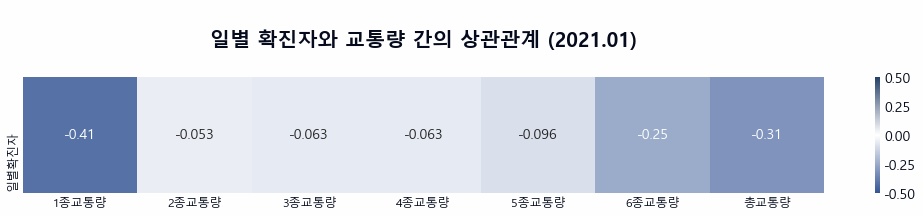

In [48]:
plt.subplots(figsize=(16,2))
jan_covid_traffic_cor=jan_covid_traffic.drop(['년도','월'],axis=1)
# 상관관계 수치 그래프 [Correlation Heatmap with Number]
jan_covid_traffic_cor=heat(jan_covid_traffic_cor)
jan_covid_traffic_cor=jan_covid_traffic_cor.T
sns.heatmap(jan_covid_traffic_cor, vmin=-0.5, vmax=0.5, annot=True,cmap=double2)
plt.title('\n일별 확진자와 교통량 간의 상관관계 (2021.01)\n', weight='bold')

plt.margins(x=0.05,y=0.05)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

1종 교통량과 일별 확진자 수의 상관계수를 확인해 보았을때 비교적 높은 상관관계를 갖는다고 볼 수 있다.
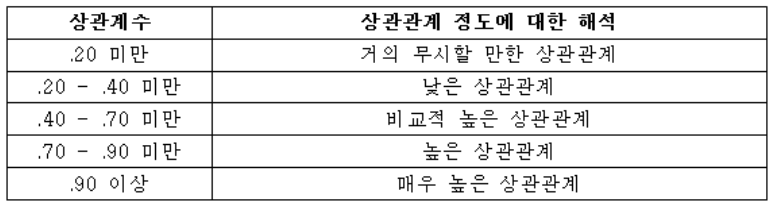



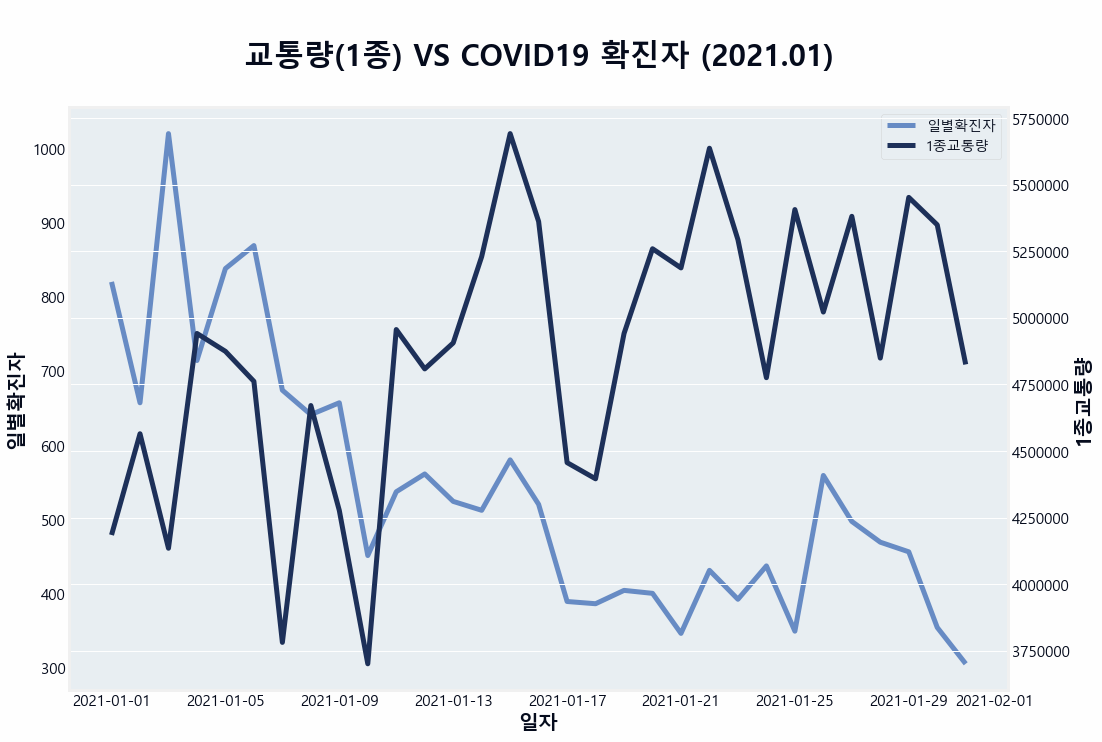

In [49]:
# 2021.01 1종교통량VS확진자수

fig, ax1=plt.subplots(figsize=(15,10))
ax2=ax1.twinx()
ax1.grid(False)
ax2.get_yaxis().get_major_formatter().set_scientific(False)
ax2.grid(color=ColorGrid)

ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.set_xlabel('일자',fontsize=20,weight='bold')
ax1.set_ylabel('일별확진자',fontsize=20,weight='bold')
ax2.tick_params(axis='y', labelsize=15)
ax2.set_ylabel('1종교통량',fontsize=20,weight='bold')


plt.title('\n교통량(1종) VS COVID19 확진자 (2021.01)\n', weight='bold', size=30)


l1=ax1.plot('일자', '일별확진자',data=covid_traffic[(covid_traffic.년도==2021)&(covid_traffic.월==1)],color=ColorLine1, linewidth='5', label='일별확진자')
l2=ax2.plot('일자', '1종교통량',data=covid_traffic[(covid_traffic.년도==2021)&(covid_traffic.월==1)], color=ColorLine2, linewidth='5', label='1중교통량')

ㅣ=l1+l2
ax1.legend(ㅣ, ['일별확진자','1종교통량'])

#### 2월 중심 분석

In [50]:
# 2020 1분기중 2월로만 그룹화

feb_traffic_data=fitst_traffic_data[(fitst_traffic_data['년도']==2020)&(fitst_traffic_data['월']==2)]
feb_traffic_data=feb_traffic_data.groupby('집계일자')['1종교통량', '2종교통량','3종교통량', '4종교통량', '5종교통량', '6종교통량', '총교통량'].sum()/(5.877788e+06)


# 2021 1분기중 2월로만 그룹화

lastfeb_traffic_data=fitst_traffic_data[(fitst_traffic_data['년도']==2021)&(fitst_traffic_data['월']==2)]
lastfeb_traffic_data=lastfeb_traffic_data.groupby('집계일자')['1종교통량', '2종교통량','3종교통량', '4종교통량', '5종교통량', '6종교통량', '총교통량'].sum()/(6.639591e+06)


In [51]:
#2020 2월 코로나 확진자 데이터 가져오기
covid_data['일별확진자']=((covid_data.decideCnt.shift()-covid_data.decideCnt))/813
feb_covid_data_new=covid_data[['stateDt','일별확진자']]
feb_covid_data_new.columns=['일자','일별확진자']
feb_covid_data_new.index=pd.to_datetime(feb_covid_data_new['일자'],format='%Y%m%d')


#2021 2월 코로나 확진자 데이터 가져오기
covid_data['일별확진자']=((covid_data.decideCnt.shift()-covid_data.decideCnt))/621
lastfeb_covid_data_n=covid_data[['stateDt','일별확진자']]
lastfeb_covid_data_n.columns=['일자','일별확진자']
lastfeb_covid_data_n.index=pd.to_datetime(lastfeb_covid_data_n['일자'],format='%Y%m%d')


In [52]:
feb_2020_covid_traffic=feb_traffic_data.join(feb_covid_data_new['일별확진자'], how='inner')
feb_2021_covid_traffic=lastfeb_traffic_data.join(lastfeb_covid_data_n['일별확진자'], how='inner')

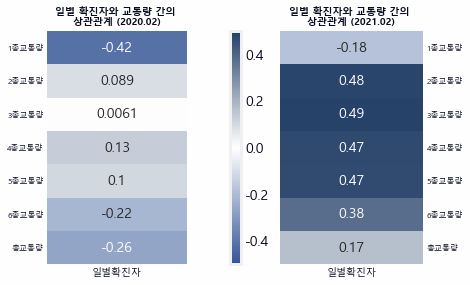

In [53]:
feb_2020_covid_traffic_heat=heat(feb_2020_covid_traffic)
feb_2021_covid_traffic_heat=heat(feb_2021_covid_traffic)

fig, (ax,ax2) = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [3, 2]})
fig.subplots_adjust(wspace=0.1)

ax2.set_title('일별 확진자와 교통량 간의 \n상관관계 (2021.02)', fontsize=10, weight='bold')
ax.set_title('일별 확진자와 교통량 간의 \n상관관계 (2020.02)', fontsize=10, weight='bold')
ax=sns.heatmap(feb_2020_covid_traffic_heat, vmin=-0.5, vmax=0.5, cmap=double2, ax=ax, cbar=False,annot=True)
fig.colorbar(ax.collections[0], ax=ax,location='right',use_gridspec=False, pad=0.2)
ax2=sns.heatmap(feb_2021_covid_traffic_heat, vmin=-0.5, vmax=0.5, cmap=double2, ax=ax2, cbar=False,annot=True)
ax.set_xticklabels(ax.get_xmajorticklabels(),fontsize=10)
ax2.set_xticklabels(ax2.get_xmajorticklabels(),fontsize=10)
ax2.yaxis.tick_right()
ax2.tick_params(rotation=0)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 8)
ax2.set_yticklabels(ax2.get_ymajorticklabels(), fontsize = 8)
plt.show()

In [54]:
feb_2020_covid_traffic['요일']=feb_2020_covid_traffic.index
feb_2021_covid_traffic['요일']=feb_2021_covid_traffic.index
feb_2021_covid_traffic.head()

,1종교통량,2종교통량,3종교통량,4종교통량,5종교통량,6종교통량,총교통량,일별확진자,요일
2021-02-01,0.780393,0.032268,0.037997,0.032387,0.045009,0.043072,0.971127,0.541063,2021-02-01
2021-02-02,0.786890,0.035401,0.040843,0.038070,0.051677,0.042959,0.995841,0.752013,2021-02-02
2021-02-03,0.781969,0.034858,0.040817,0.038502,0.052838,0.042151,0.991135,0.726248,2021-02-03
2021-02-04,0.752439,0.033535,0.039756,0.036923,0.050278,0.040003,0.952934,0.595813,2021-02-04
2021-02-05,0.881208,0.035219,0.041369,0.037873,0.053373,0.046230,1.095271,0.628019,2021-02-05


Text(0.5, 0.98, '\n2020년도 2월 차종,일별확진자 비교\n')

<Figure size 432x288 with 0 Axes>

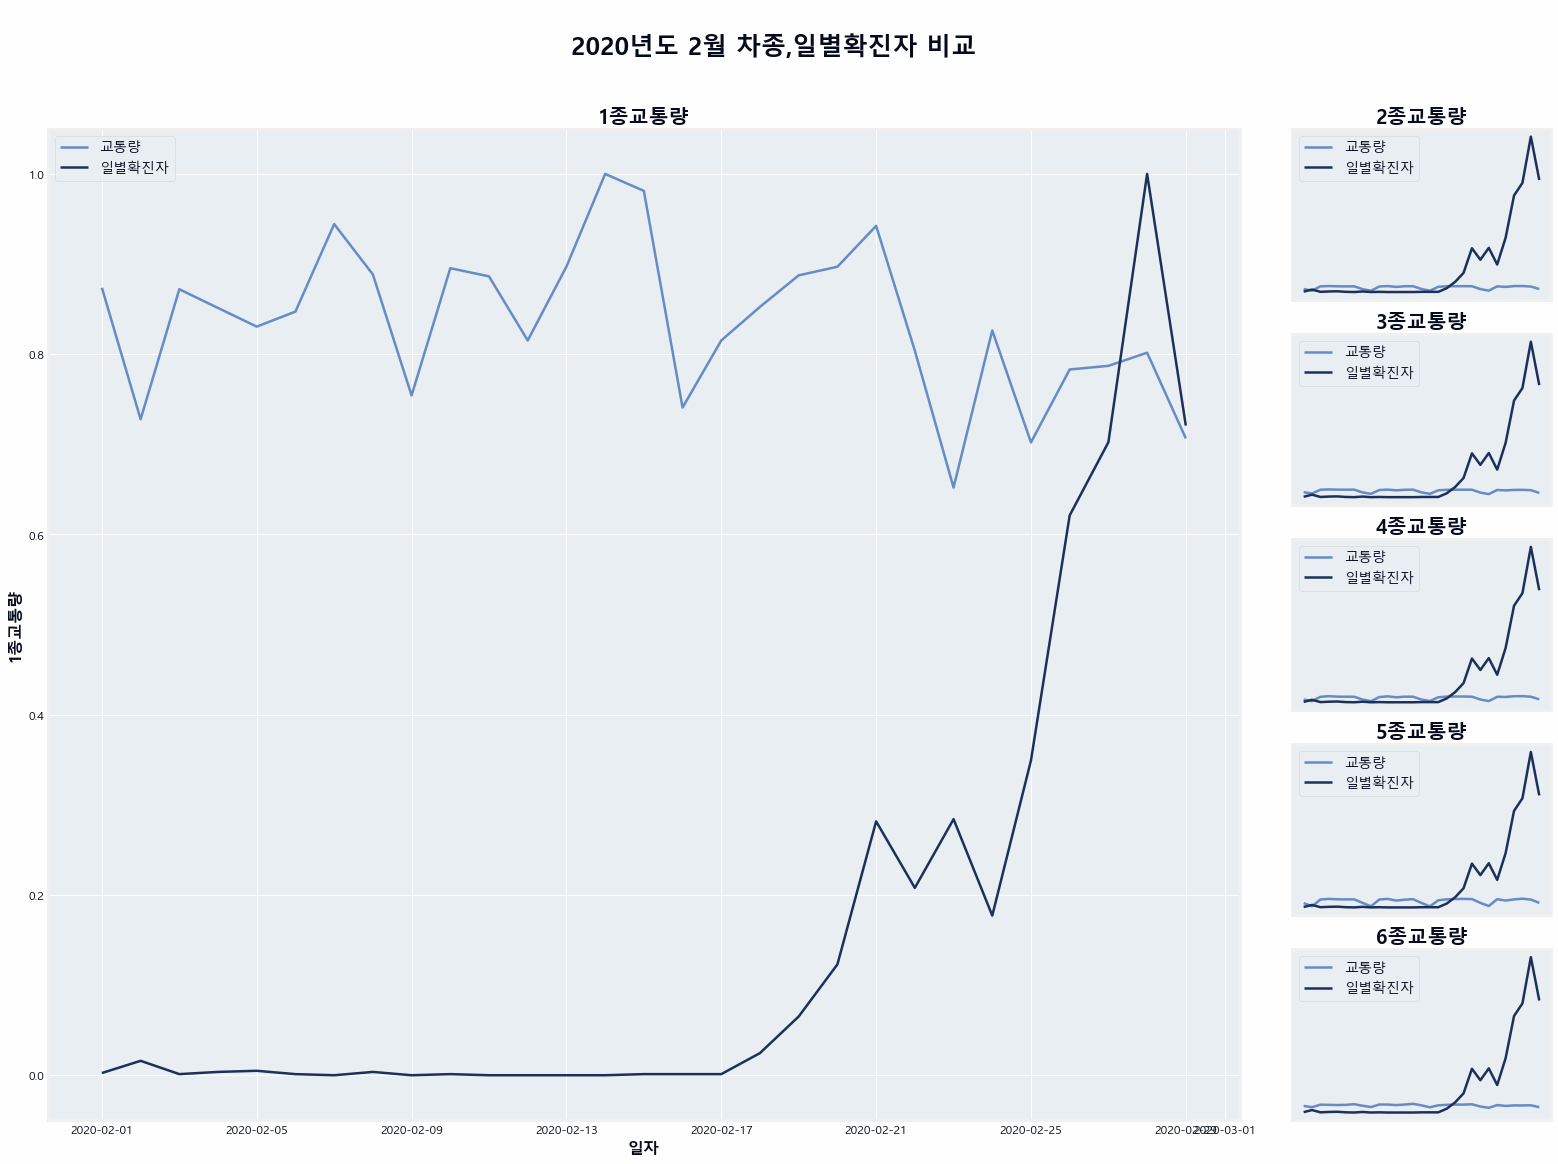

In [55]:
# 2020년도 2월 차종vs일별확진자 그래프 시각화
traffic=['1종교통량','2종교통량','3종교통량','4종교통량','5종교통량','6종교통량']
plt.figure(0)
plt.figure(figsize=(24,17))
ax1 = plt.subplot2grid((5,5), (0,0), colspan=4,rowspan=5)
ax2 = plt.subplot2grid((5,5), (0,4), rowspan=1)
ax3 = plt.subplot2grid((5,5), (1,4), rowspan=1)
ax4 = plt.subplot2grid((5,5), (2,4), rowspan=1)
ax5 = plt.subplot2grid((5,5), (3,4), rowspan=1)
ax6 = plt.subplot2grid((5,5), (4,4), rowspan=1)
axis_t=[ax1,ax2,ax3,ax4,ax5,ax6]

for idx,i in enumerate(axis_t):
    i.grid(color=ColorGrid) 
    if idx>=1:
        i.set_xticks([])
        i.set_yticks([])
    if idx==0:
        i.tick_params(axis='x', labelsize=12)
        i.tick_params(axis='y', labelsize=12)
        i.set_xlabel('일자',fontsize=16,weight='bold')
        i.set_ylabel('1종교통량',fontsize=16,weight='bold')
    sns.lineplot(x='요일', y=traffic[idx], data=feb_2020_covid_traffic,ax=i,color=ColorLine1, linewidth='2.5',label='교통량')
    i.set_title(traffic[idx], weight='bold', size=20)
    sns.lineplot(x='요일', y='일별확진자', data=feb_2020_covid_traffic,ax=i,color=ColorLine2, linewidth='2.5',label='일별확진자')
    
plt.suptitle('\n2020년도 2월 차종,일별확진자 비교\n',weight='bold', fontsize=25)

<Figure size 432x288 with 0 Axes>

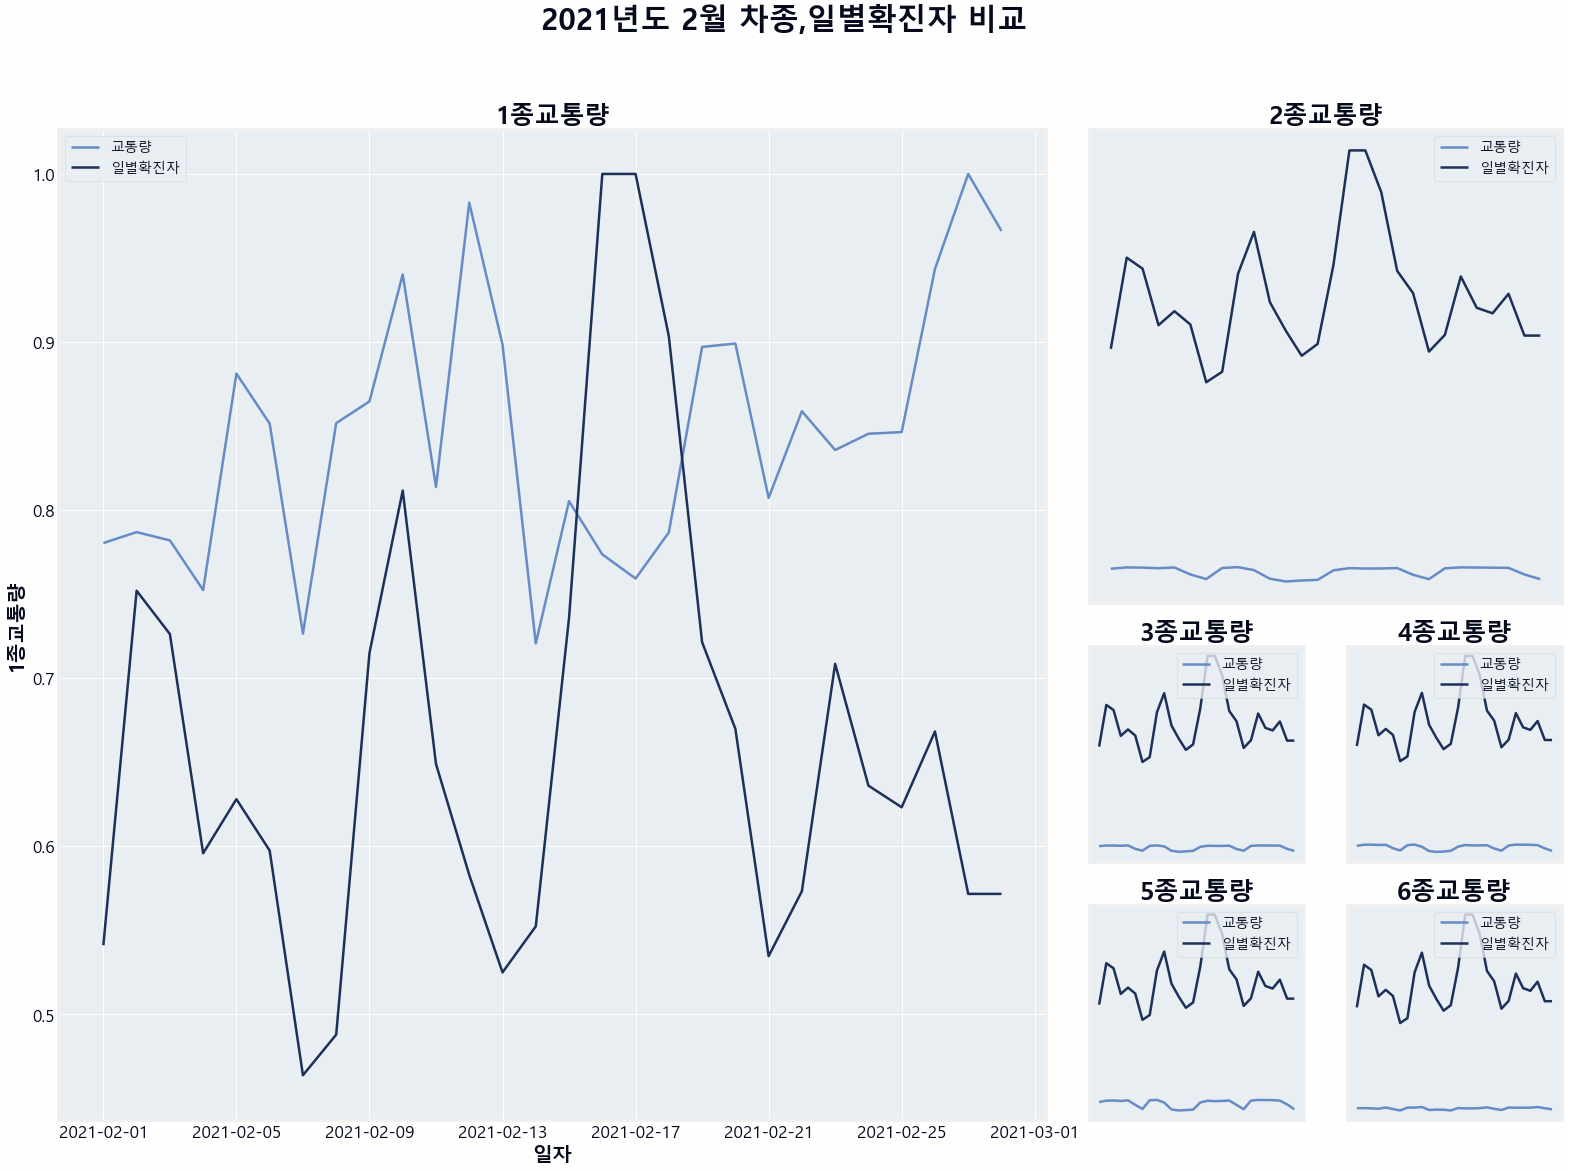

In [56]:
## 2021년도 2월 차종vs일별확진자 그래프 시각화
traffic=['1종교통량','2종교통량','3종교통량','4종교통량','5종교통량','6종교통량']
a=[ax1,ax2,ax3,ax4,ax5,ax6]
plt.figure(0)
plt.figure(figsize=(24,17))
ax1 = plt.subplot2grid((4,6), (0,0), colspan=4,rowspan=4)
ax2 = plt.subplot2grid((4,6), (0,4), colspan=2,rowspan=2)
ax3 = plt.subplot2grid((4,6), (2,4), rowspan=1)
ax4 = plt.subplot2grid((4,6), (2,5), rowspan=1)
ax5 = plt.subplot2grid((4,6), (3,4), rowspan=1)
ax6 = plt.subplot2grid((4,6), (3,5), rowspan=1)
axis_t=[ax1,ax2,ax3,ax4,ax5,ax6]

for idx,i in enumerate(axis_t):
    i.grid(color=ColorGrid) 
    if idx>=1:
        i.set_xticks([])
        i.set_yticks([])
    if idx==0:
        i.tick_params(axis='x', labelsize=17)
        i.tick_params(axis='y', labelsize=17)
        i.set_xlabel('일자',fontsize=20,weight='bold')
        i.set_ylabel('1종교통량',fontsize=20,weight='bold')
    w=sns.lineplot(x='요일', y=traffic[idx], data=feb_2021_covid_traffic,ax=i,color=ColorLine1, linewidth='2.5',label='교통량')
    i.set_title(traffic[idx], weight='bold', size=25)
    w2=sns.lineplot(x='요일', y='일별확진자', data=feb_2021_covid_traffic,ax=i,color=ColorLine2, linewidth='2.5',label='일별확진자')
plt.suptitle('2021년도 2월 차종,일별확진자 비교',fontsize=30, weight='bold')
fig.tight_layout()

# 🤦‍♀️🤦‍🤦‍🤦‍🤦‍🤦‍🤦‍🤦‍
